<a href="https://colab.research.google.com/github/MariaGabrielaAlvesZuppardo/SeriesTemporaisCin/blob/main/Lista1_ARIMA_AR_MA_BTCUSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

In [ ]:
!pip install statsmodels

In [ ]:
!pip install statsforecast

# Libraries

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from pandas import DataFrame
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt


from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import jarque_bera, skew, kurtosis


from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string

## Statistical Tests

In [ ]:
def adf_test(series,title=''):
    print(f'Augmented Dickey-Fuller Test')
    dftest = adfuller(series.dropna(),autolag='AIC')

    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(dftest[0:4],index=labels)

    for key,val in dftest[4].items():
        out[f'critical value ({key})']=val

    print(out.to_string())

    if dftest[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
    print()

def kpss_value(series):
    import statsmodels.api as sm # Importing statsmodels
    from statsmodels.tools.sm_exceptions import InterpolationWarning
    import warnings
    kpss = None
    # Suprimir apenas o InterpolationWarning ao executar o KPSS
    with warnings.catch_warnings():
      warnings.filterwarnings("ignore", category=InterpolationWarning)
      kpss= sm.tsa.stattools.kpss(series.dropna().values.reshape(-1), nlags='auto')[1]
    return kpss

def kpss_test(series):

    print('Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS)')
    print('H0: Data is non-stationary')
    print('Result:')
    kpss = kpss_value(series)
    alpha=0.05
    print(f'* p-value = {round(kpss,2)}. alpha = {round(alpha,2)}')
    if(kpss<=alpha):
        print('* Series is non-stationary; differencing is required.')
    else:
        print('* Series is stationary; no differencing required.')
    print()

# Ljung-Box
def ljungbox_values(resid):
  lb = acorr_ljungbox(resid, lags=[1], return_df=True)
  return lb['lb_stat'].iloc[0], lb['lb_pvalue'].iloc[0]

# Heteroscedasticidade (ARCH)
def heteroskedasticity_values(resid):
  arch = het_arch(resid)
  arch_lm_stat = arch[0]
  p_value = arch[1]
  return arch_lm_stat, p_value

# Jarque-Bera
def jarque_bera_values(resid):
  jb = jarque_bera(resid)
  return jb.statistic, jb.pvalue

# Assimetria e Curtose
def skewness_kurtosis_values(resid):
  return skew(resid), kurtosis(resid, fisher=False)


def ljungbox_test(series):
    """
    Aplica o teste de Ljung-Box para verificar autocorrelação dos dados.
    """
    from statsmodels.stats.diagnostic import acorr_ljungbox

    ljung_box_results = acorr_ljungbox(series, return_df=True, lags=[20])

    p_value = ljung_box_results['lb_pvalue'].values[0]
    print('\nLJung-Box Test\nH0:has no autocorrelation')
    alpha = 0.05
    print(f'p-valor = {round(p_value,2)}\nalpha = {round(alpha,2)}')
    if p_value > alpha:
        print('Data has no autocorrelation')
    else:
        print('Data has autocorrelation')
    print()

def stationary_test(series):
  print('==============')
  print('ORGINAL SERIES')
  print('==============')
  adf_test(series)

  print('==============')
  print('1st DIFF')
  print('==============')
  diff1 = series.copy()
  diff1['y'] = diff1['y'].diff(1)
  diff1.dropna(inplace=True)
  adf_test(diff1)
  kpss_test(diff1)
  print()


  print('==============')
  print('2st DIFF')
  print('==============')
  diff2 = diff1.copy()
  diff2['y'] = diff2['y'].diff(1)
  diff2.dropna(inplace=True)
  adf_test(diff2)
  kpss_test(diff2)

## Evaluation Metrics

In [ ]:

def prediction_metrics(test, predictions, model=None):
  # Cálculo das métricas de avaliação
  mse = mean_squared_error(test['y'], predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(test['y'], predictions)
  r2 = r2_score(test['y'], predictions)

  # Calcular MAPE (Mean Absolute Percentage Error)
  mape = np.mean(np.abs((test['y'] - predictions) / test['y'])) * 100

  # Calcular SMAPE (Symmetric Mean Absolute Percentage Error)
  smape = np.mean(2 * np.abs(test['y'] - predictions) /
                (np.abs(test['y']) + np.abs(predictions))) * 100
  values = pd.DataFrame({'model':[model],'mse':[mse],'rmse':[rmse],'mae':[mae],'r2':[r2],'mape':[mape],'smape':[smape]})
  return values



def model_metrics(fitted, model=None, resid=None):
  if resid == None:
    resid = fitted.filter_results.standardized_forecasts_error[0]#fitted.resid

  aic = fitted.aic
  bic = fitted.bic
  hqic = fitted.hqic
  llf = fitted.llf  # log-likelihood da função de verossimilhança

  values = pd.DataFrame({'model':[model],'aic':[aic],'bic':[bic],'hqic':[hqic],'llf':[llf]})
  return values


def rank_models(df):
    df_ranked = df.copy()

    # Lista das colunas a serem ranqueadas (exceto 'model')
    metric_cols = [col for col in df.columns if col != 'model']

    # Aplica ranking: menor valor = melhor, exceto para 'r2', que deve ranquear do maior para o menor
    for col in metric_cols:
        ascending = False if col.lower() in ['r2','llf'] else True
        df_ranked[f'rank_{col}'] = df[col].rank(ascending=ascending, method='min')

    # Soma os rankings para gerar o ranking final
    rank_cols = [f'rank_{col}' for col in metric_cols]
    df_ranked['final_rank'] = df_ranked[rank_cols].sum(axis=1).rank(method='min')

    # Ordena pelo ranking final
    df_ranked = df_ranked.sort_values(by='final_rank').reset_index(drop=True)

    return df_ranked

## Model Evaluation

In [ ]:
def inc_prediction(train, test, p, d, q):
  import warnings
  warnings.simplefilter(action='ignore', category=FutureWarning)

  history = [ x for x in train.values.reshape(-1)]
  pred = list()
  # walk-forward validation
  for t in range(len(test)):
    model = ARIMA(history, order=(p,d,q))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    pred.append(yhat)
    obs = test['y'].iloc[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
  return pred, model_fit

def _model_name(p,d,q):
  name = None
  if (p==0 and d==0):
    name = f'MA({q})'
  elif (q==0 and d ==0):
    name = f'AR({p})'
  else:
    name = f'ARIMA({p},{d},{q})'
  return name


def model_evaluation(train, test, p, d, q):
  f1, m1 = __model_evaluation(train, test, p, d, q, inc=False)
  f2, m2 = __model_evaluation(train, test, p, d, q, inc=True)
  f = pd.concat([f1,f2],axis=0)
  m = pd.concat([m1,m2],axis=0)
  return f, m


def __model_evaluation(train, test, p, d, q, inc=False):
  model_name = _model_name(p,d,q)
  suf = 'single' if not inc else 'incremental'
  model_name += f'({suf}_testing)'
  print('=================================')
  print(model_name)
  print('=================================')


  if not inc:
    model = ARIMA(train, order=(p,d,q))
    fitted = model.fit()
    pred = fitted.forecast(len(test))
  else:
    pred, fitted = inc_prediction(train, test, p, d, q)


  print('------------------')
  print('MODELO')
  print('------------------')
  print(fitted.summary())
  mdl_metrics = model_metrics(fitted, model=model_name)
  print(mdl_metrics)
  print('-------------------')
  print('RESÍDUO')
  print('-------------------')
  resid = pd.Series(fitted.filter_results.standardized_forecasts_error[0])
  print(resid.describe())
  ljungbox_test(resid)
  print()
  adf_test(resid)
  fitted.plot_diagnostics(figsize=(18,12))
  plt.show()

  print('-------------------')
  print('PREVISÃO')
  print('-------------------')

  plt.figure()
  train['y'].plot(legend=True, label='TRAIN')
  test['y'].plot(legend=True, label='TEST')
  pd.DataFrame({'ds':test.index, 'y':pred}).set_index('ds')['y'].plot(legend=True, label='PREDICTIONS', figsize=(12, 6))
  plt.show()

  pred_metrics = prediction_metrics(test, pred, model=model_name)
  print(pred_metrics)
  return pred_metrics, mdl_metrics

## ACF and PACF

In [ ]:
def plot_acf_pacf(series, lags=15, title='series'):
  fig, axes = plt.subplots(1,3, figsize=(20,5))
  axes[0].plot(series); axes[0].set_title(title)
  plot_acf(series, ax=axes[1],lags=lags)
  plot_pacf(series, ax=axes[2],lags=lags)

  # Rotaciona os rótulos do eixo X apenas nos gráficos à esquerda
  for ax in axes[:]:
      for label in ax.get_xticklabels():
          label.set_rotation(45)

  fig.tight_layout()
  fig.show()

def plot_diff1(series, lags=15, title='1st diff series'):
  diff1 = series.copy()
  diff1['y'] = diff1['y'].diff(1)
  diff1.dropna(inplace=True)
  plot_acf_pacf(diff1, lags=lags, title=title)
  return diff1

def plot_acf_pacf_diff(series, lags=15):
  plot_acf_pacf(series, lags=lags)
  diff1_kpss = None
  diff2_kpss = None
  data_kpss = kpss_value(series)
  if (data_kpss <= 0.05):
    diff1 = plot_diff1(series, lags=lags)
    diff1_kpss = kpss_value(diff1)
    if (diff1_kpss <= 0.05):
      diff2 = plot_diff1(diff1, lags=lags, title='2nd diff series')
      diff2_kpss = kpss_value(diff2)
  return data_kpss, diff1_kpss, diff2_kpss

# Load Data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


<Axes: title={'center': 'SERIES'}, xlabel='Date'>

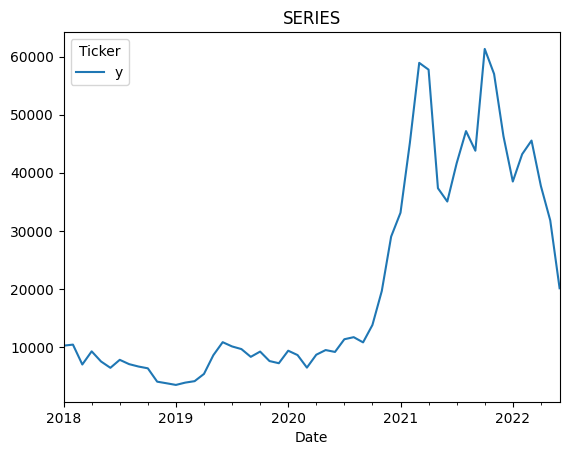

In [ ]:
start_date = datetime(2018, 1, 1)
end_date = datetime (2022, 6, 30)
ticker = 'BTC-USD'
df =yf.download(ticker, start=start_date, end=end_date)['Close']
df = df.rename(columns={ticker:'y'})
df = df.resample('ME').last()
df.plot(title="SERIES")

In [ ]:
log_flag = 0
if log_flag == 1:
  df=np.log(df)
  df.plot()

# Train / Test

train.shape=(37, 1)
test.shape=(17, 1)


<Axes: title={'center': 'TRAIN'}, xlabel='Date'>

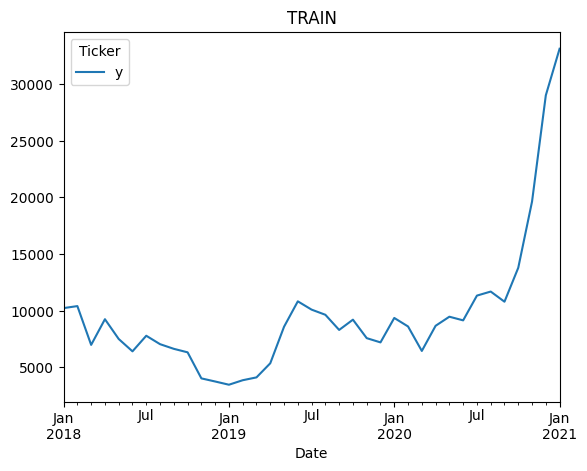

In [ ]:
size = int(len(df) * 0.7)
train, test = df[0:size], df[size:len(df)]
h = len(test)
print(f'train.shape={train.shape}')
print(f'test.shape={test.shape}')
train.plot(title='TRAIN')


# Analysis

## Methodology

**1. Estacionariedade**

"Os logaritmos estabilizam a variância, enquanto a diferença sazonal remove a sazonalidade e a tendência (...)

Há vários testes de raiz unitária disponíveis, que são baseados em diferentes suposições e podem levar a respostas conflitantes. Em nossa análise, usamos o teste de Kwiatkowski-Phillips-Schmidt-Shin (KPSS) (Kwiatkowski et al., 1992). Neste teste, a hipótese nula é que os dados são estacionários, e procuramos evidências de que a hipótese nula é falsa. Consequentemente, valores-p pequenos (por exemplo, menores que 0,05) sugerem que a diferenciação é necessária." [1]

**2. Diferenciação**

"Um modelo estreitamente relacionado permite que as diferenças tenham uma média diferente de zero. (...) O valor de c é a média das mudanças entre observações consecutivas. Se c for positivo, então a mudança média é um aumento no valor de yt. Assim, yt tenderá a aumentar. No entanto, se c for negativo, yt tenderá a diminuir. Este é o modelo por trás do método Drift (...)

Ocasionalmente, os dados diferenciados podem não parecer estacionários, e pode ser necessário diferenciar os dados uma segunda vez para obter uma série estacionária (...) se os dados tiverem um padrão sazonal forte, recomendamos que a diferenciação sazonal seja feita primeiro, pois a série resultante às vezes será estacionária e não haverá necessidade de uma primeira diferenciação adicional. Se a primeira diferenciação for feita primeiro, ainda haverá sazonalidade presente. (...)

Tenha cuidado ao aplicar mais diferenciações do que o necessário, pois isso pode induzir dinâmicas ou autocorrelações falsas que não existem realmente na série temporal. Portanto, faça o mínimo de diferenciações necessário para obter uma série estacionária. (...) É importante que, se a diferenciação for utilizada, as diferenças sejam interpretáveis." [1]

**3. ACF e PACF**

"Se os dados seguem um modelo ARIMA(p,d,0) ou ARIMA(0,d,q), os gráficos de ACF e PACF podem ser úteis para determinar os valores de p ou q. Se p e q forem ambos positivos, os gráficos não ajudam na escolha dos valores apropriados de p e q.

Os dados podem seguir um modelo ARIMA(p,d,0) se os gráficos de ACF e PACF dos dados diferenciados apresentarem os seguintes padrões:

* a ACF decai exponencialmente ou tem um padrão sinusoidal;
* há um pico significativo na defasagem p da PACF, mas nenhum além da defasagem p.

Os dados podem seguir um modelo ARIMA(0,d,q) se os gráficos de ACF e PACF dos dados diferenciados mostrarem os seguintes padrões:

* a PACF decai exponencialmente ou tem um padrão sinusoidal;
* há um pico significativo na defasagem q da PACF, mas nenhum além da defasagem q." [2]

O valor de p ou q será a última defasagem com pico significativo no gráfico PACF ou ACF, respectivamente. [2]

**Referência Bibliográfica**
* [1] https://otexts.com/fpppg/stationarity.html
* [2] https://otexts.com/fpppg/non-seasonal-arima.html

## Differentiation and tests

In [ ]:
stationary_test(train)

ORGINAL SERIES
Augmented Dickey-Fuller Test
ADF test statistic       2.992476
p-value                  1.000000
# lags used              0.000000
# observations          36.000000
critical value (1%)     -3.626652
critical value (5%)     -2.945951
critical value (10%)    -2.611671
Fail to reject the null hypothesis
Data has a unit root and is non-stationary

1st DIFF
Augmented Dickey-Fuller Test
ADF test statistic      -3.369267
p-value                  0.012052
# lags used              0.000000
# observations          35.000000
critical value (1%)     -3.632743
critical value (5%)     -2.948510
critical value (10%)    -2.613017
Reject the null hypothesis
Data has no unit root and is stationary

Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS)
H0: Data is non-stationary
Result:
* p-value = 0.03. alpha = 0.05
* Series is non-stationary; differencing is required.


2st DIFF
Augmented Dickey-Fuller Test
ADF test statistic     -6.657371e+00
p-value                 4.945186e-09
# lags used    

## Plotting

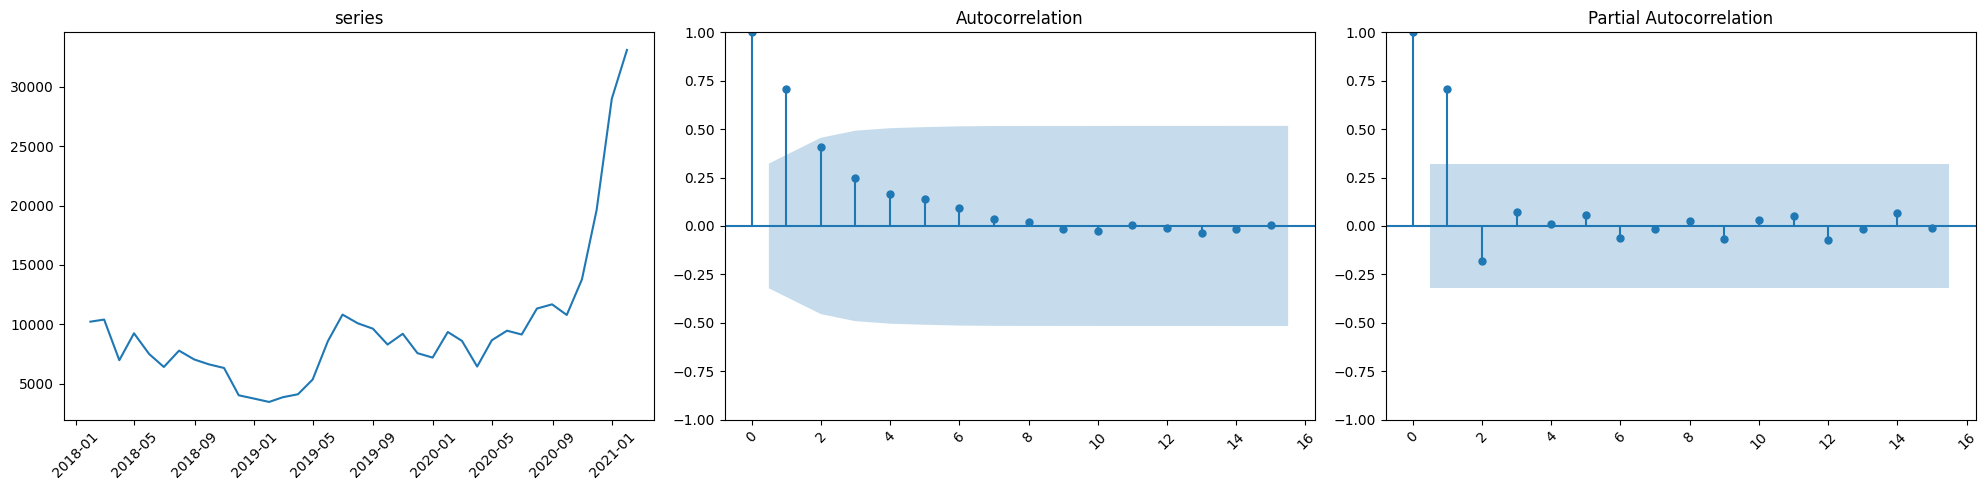

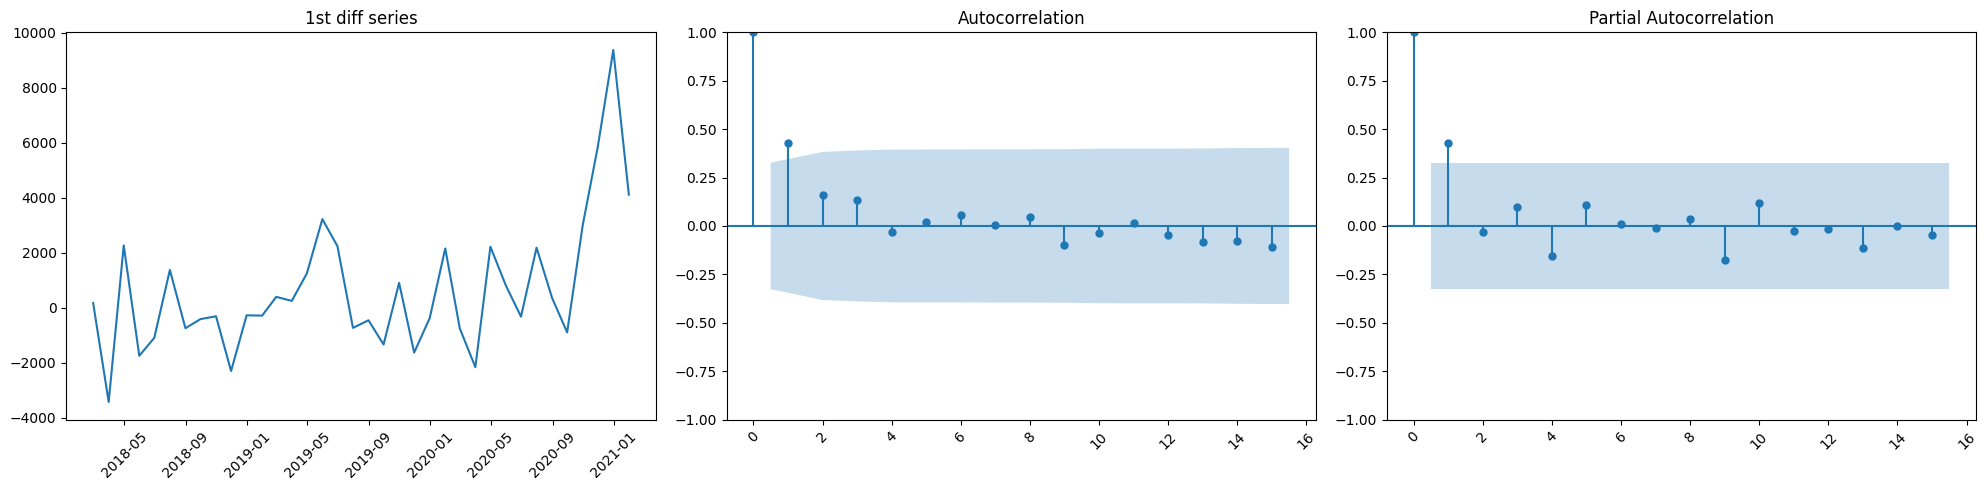

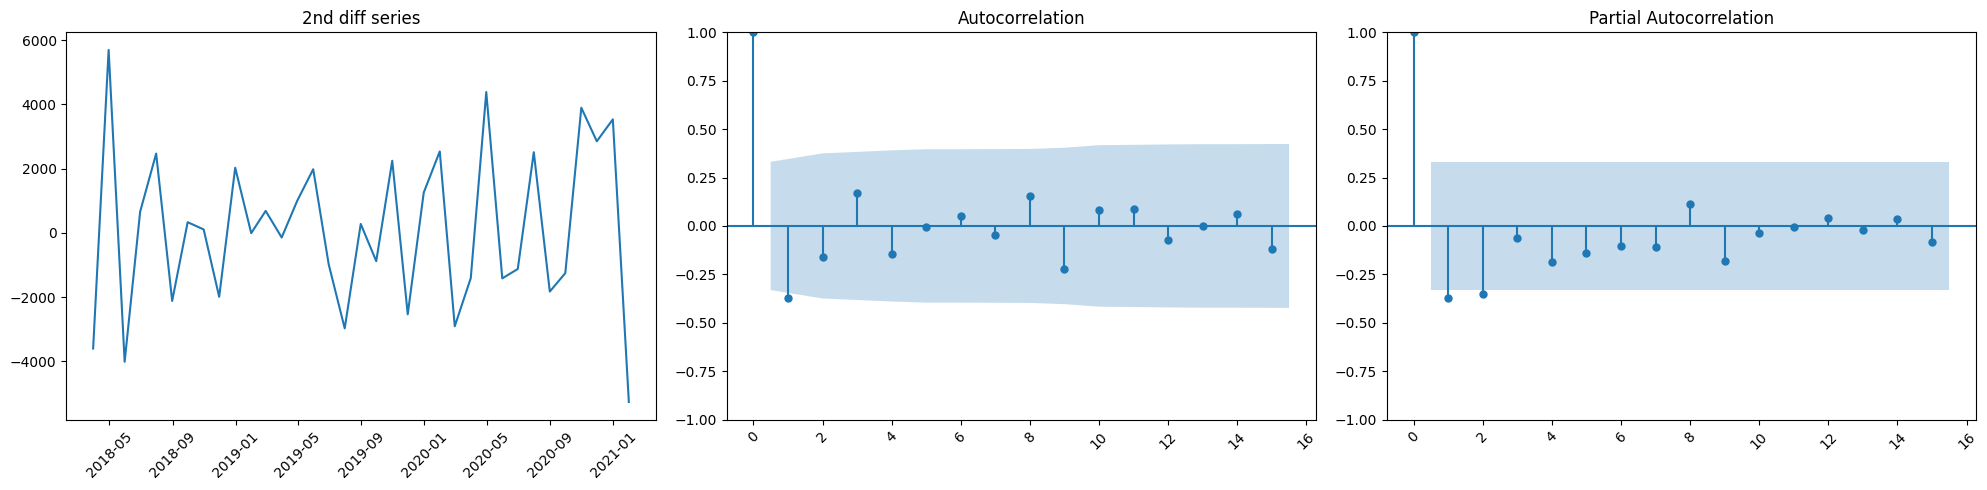

In [ ]:

_,_,_ = plot_acf_pacf_diff(train)

## Conclusion

Após a 1ª diferenciação, os testes ADF e KPSS divergiram a cerca da estacionariedade dos dados, por isso uma 2ª diferenciação foi realizada.

Visualmente a séria com a duplamente diferenciada é bastante estacionária, enquanto a com 1ª diferenciação possui um certo aumento de variância a partir de novembro de 2020. Sendo assim, devemos considerar o hiper-parâmetro 'd' como igual a 2.  

No contexto da 2ª diferenciação, o gráfico ACF mostra que o lag 1 está fora da banda de confiança, podendo o hiper-parâmetro 'q' ser igual a 1. Quanto ao gráfico PACF, o último lag fora da banda de confianção é o 2, podendo ser este o valor do hiper-parâmetro 'p'.

Contudo, como os testes ADF e KPSS discordaram na 1ª diferenciação, e os lags mais significativos da série duplamente diferenciada se tornaram negativos, realizarei experimentos não só com esta, mas também com a primeira, objetivando, assim, afastar qualquer alegação de superdiferenciação. Sendo assim, no contexto da 1ª diferenciação, os valores para os hiperparâmetros 'p', 'd' e 'q' poderiam ser todos iguais a 1.

Por fim, realizarei a comparação dos modelos com base nos critérios AIC e BIC, tanto para a série com primeira quanto com segunda diferenciação. Além disso, será conduzido um experimento com o AutoARIMA, com o objetivo de descartar qualquer indício de superdiferenciação e, assim, confirmar a adequação, ou não, da segunda diferenciação. Ressalte-se, ainda, que como os hiperparâmetros 'p' e 'q' apresentaram valores distintos de zero — indicando a presença de lags significativos em ambos os componentes —, serão realizados testes adicionais omitindo cada um deles isoladamente, conforme orientações estabelecidas na seção de Metodologia.

# Modelo ARIMA

## ARIMA(2,2,1)

ARIMA(2,2,1)(single_testing)
------------------
MODELO
------------------
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   37
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -316.211
Date:                Tue, 15 Apr 2025   AIC                            640.422
Time:                        12:35:19   BIC                            646.643
Sample:                    01-31-2018   HQIC                           642.570
                         - 01-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7275      0.248     -2.928      0.003      -1.214      -0.241
ar.L2         -0.5332      0.181     -2.950      0.003   

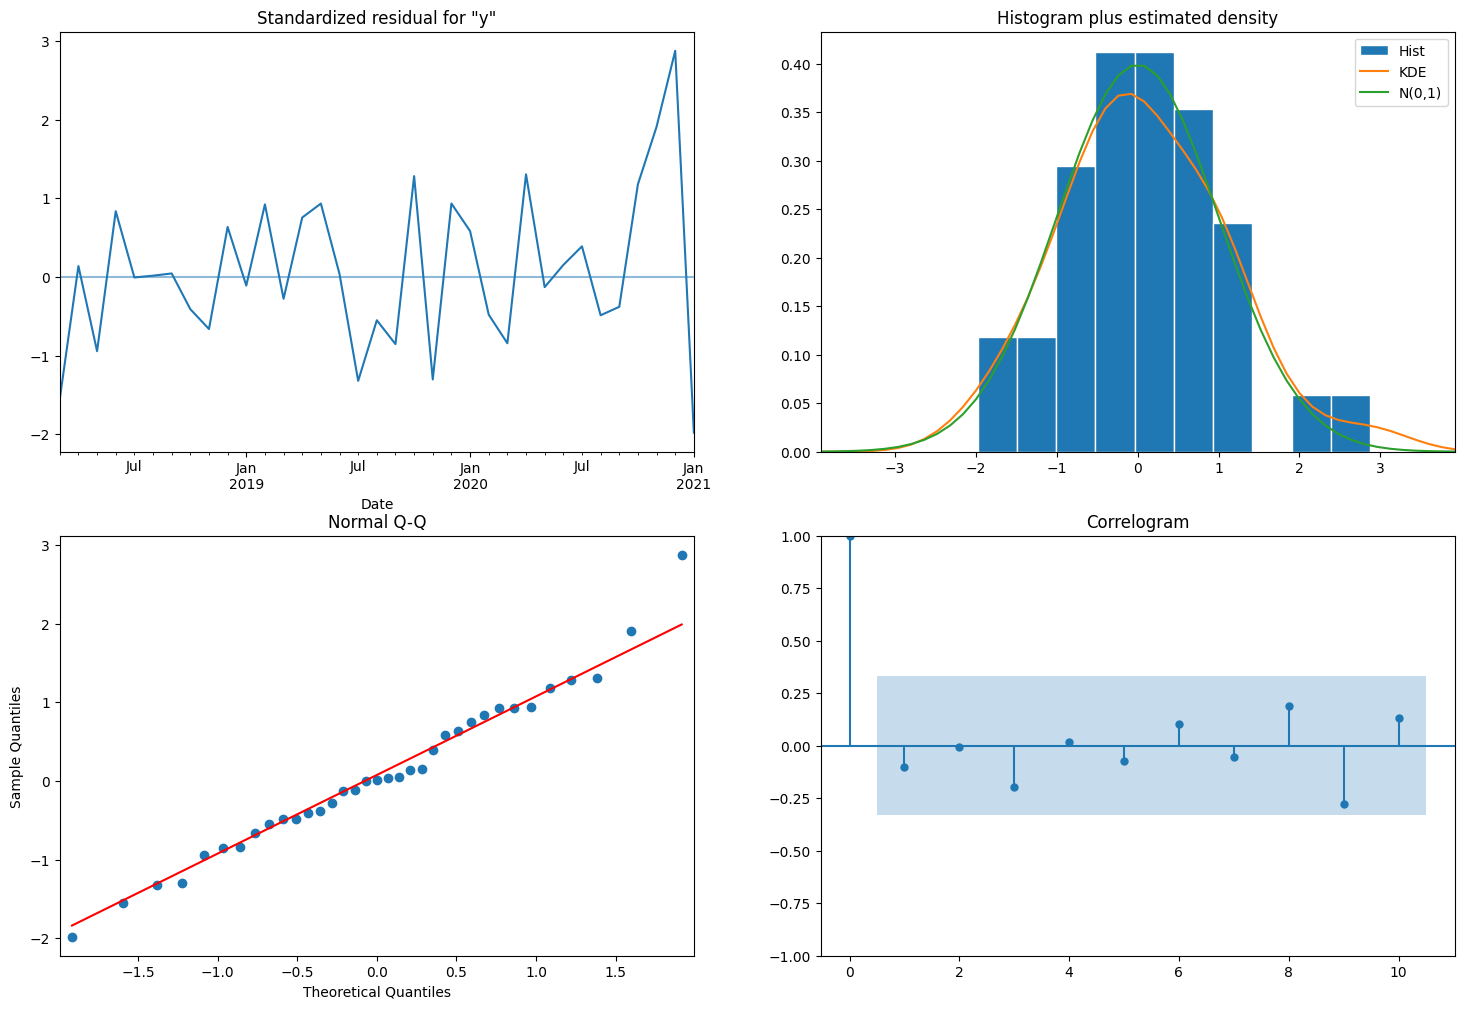

-------------------
PREVISÃO
-------------------


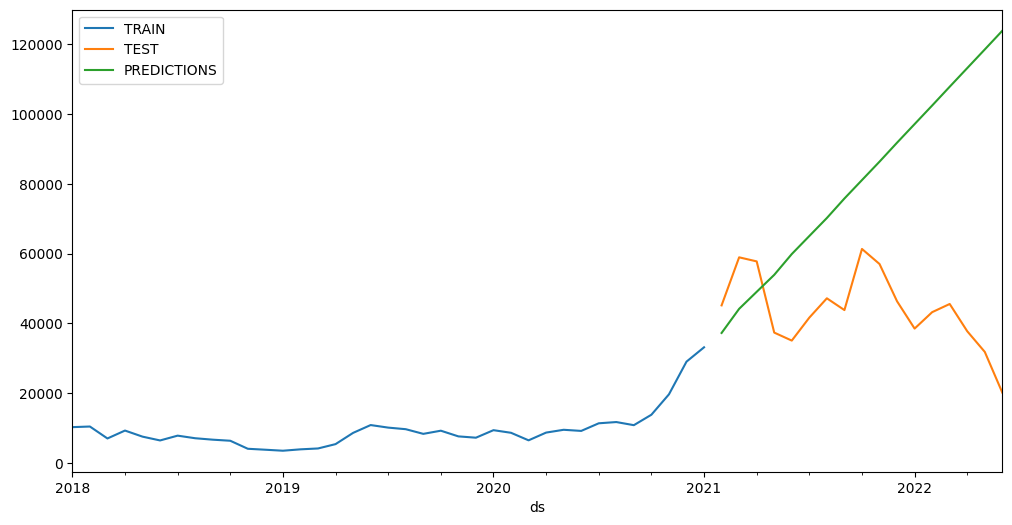

                          model           mse          rmse           mae  \
0  ARIMA(2,2,1)(single_testing)  2.441001e+09  49406.491662  40707.432144   

          r2      mape      smape  
0 -21.790994  114.6235  60.748666  
ARIMA(2,2,1)(incremental_testing)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


------------------
MODELO
------------------
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   53
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -511.964
Date:                Tue, 15 Apr 2025   AIC                           1031.928
Time:                        12:35:30   BIC                           1039.655
Sample:                             0   HQIC                          1034.880
                                 - 53                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2905      0.155      1.877      0.061      -0.013       0.594
ar.L2         -0.3275      0.186     -1.762      0.078      -0.692       0.037
ma.L1  

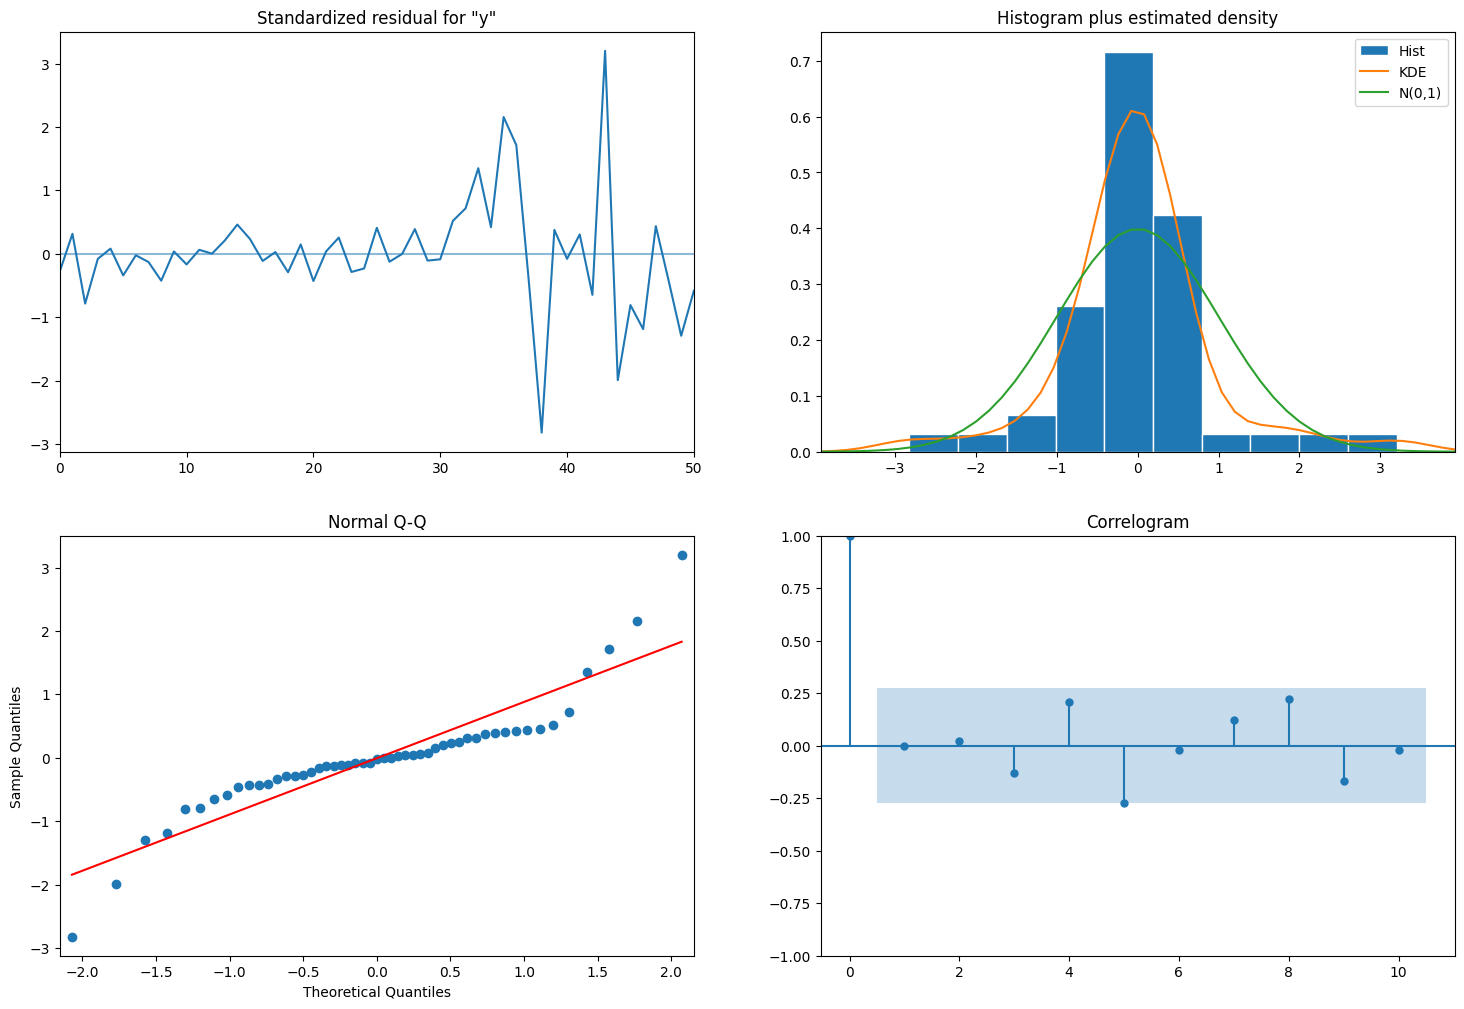

-------------------
PREVISÃO
-------------------


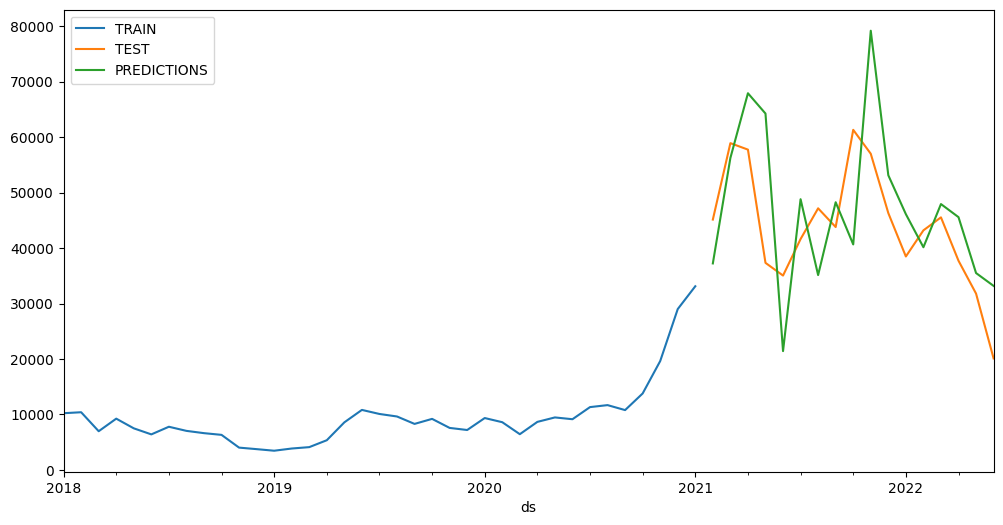

                               model           mse          rmse  \
0  ARIMA(2,2,1)(incremental_testing)  1.520765e+08  12331.929156   

            mae        r2       mape      smape  
0  10139.052584 -0.419898  24.744366  23.081878  


In [ ]:
pred_arima221_met, arima221_met = model_evaluation(train, test, 2, 2, 1)

## ARIMA(2,2,0)

ARIMA(2,2,0)(single_testing)
------------------
MODELO
------------------
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   37
Model:                 ARIMA(2, 2, 0)   Log Likelihood                -317.261
Date:                Tue, 15 Apr 2025   AIC                            640.521
Time:                        12:35:33   BIC                            645.187
Sample:                    01-31-2018   HQIC                           642.132
                         - 01-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3859      0.135     -2.853      0.004      -0.651      -0.121
ar.L2         -0.4800      0.130     -3.686      0.000   

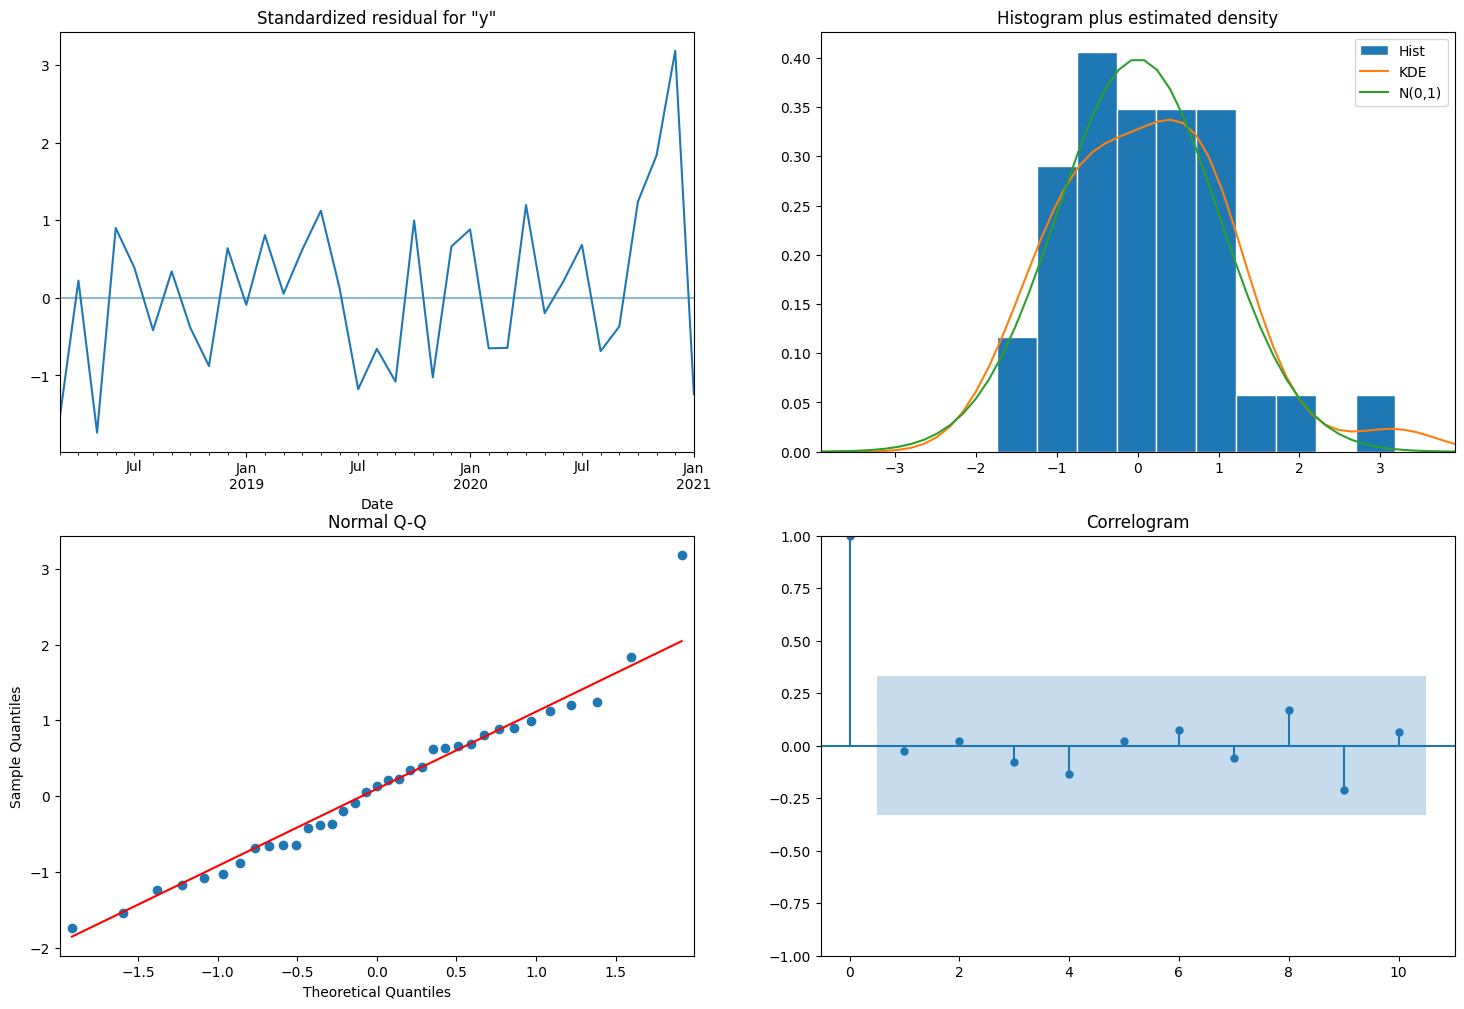

-------------------
PREVISÃO
-------------------


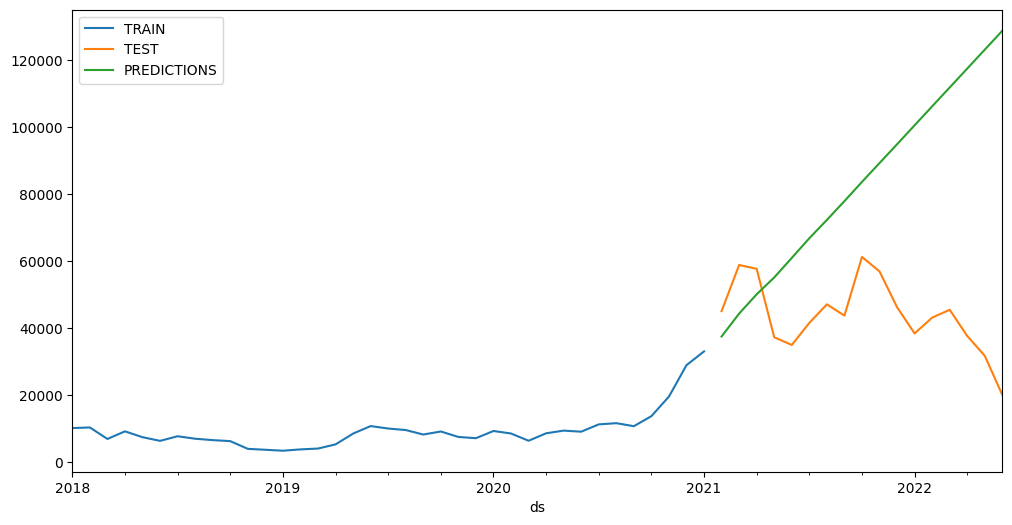

                          model           mse          rmse           mae  \
0  ARIMA(2,2,0)(single_testing)  2.734754e+09  52294.879798  43131.942749   

         r2        mape      smape  
0 -24.53369  121.219225  62.761561  
ARIMA(2,2,0)(incremental_testing)
------------------
MODELO
------------------
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   53
Model:                 ARIMA(2, 2, 0)   Log Likelihood                -518.078
Date:                Tue, 15 Apr 2025   AIC                           1042.155
Time:                        12:35:38   BIC                           1047.951
Sample:                             0   HQIC                          1044.370
                                 - 53                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      

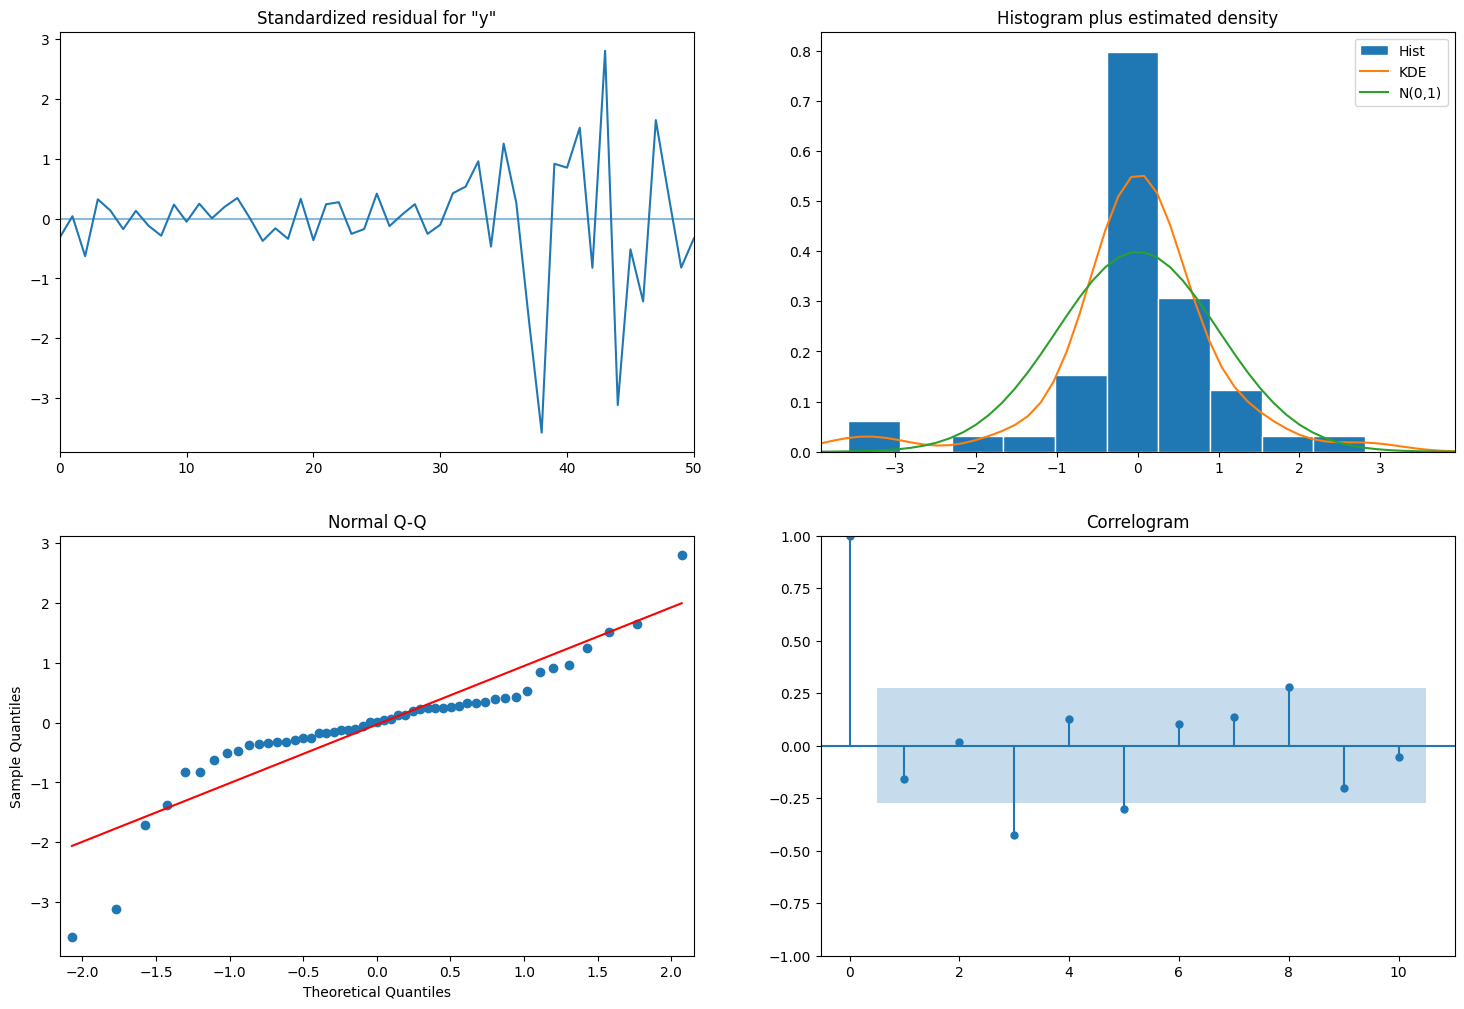

-------------------
PREVISÃO
-------------------


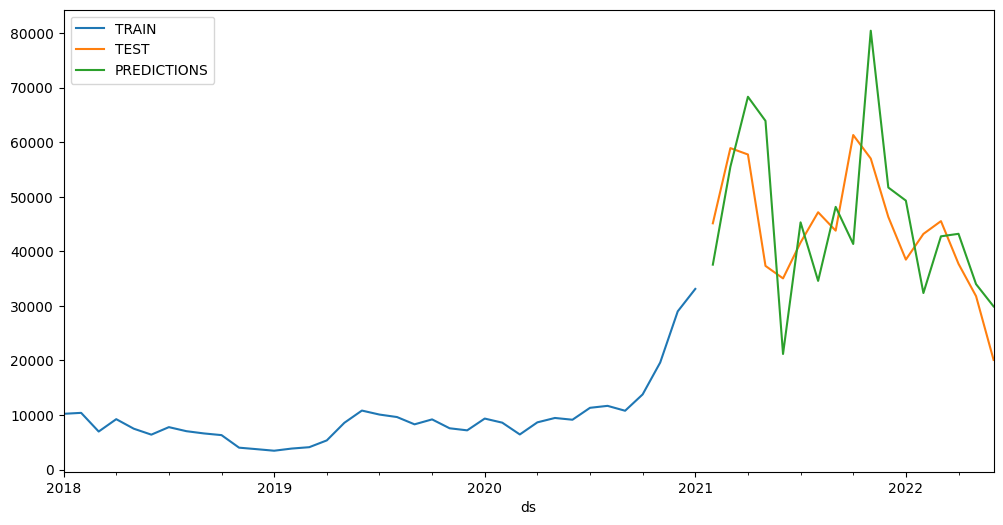

                               model           mse          rmse          mae  \
0  ARIMA(2,2,0)(incremental_testing)  1.541356e+08  12415.135954  10197.66842   

         r2       mape      smape  
0 -0.439124  24.234099  23.217382  


In [ ]:
pred_arima220_met, arima220_met = model_evaluation(train, test, 2, 2, 0)

## ARIMA(0,2,1)

ARIMA(0,2,1)(single_testing)
------------------
MODELO
------------------
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   37
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -321.061
Date:                Tue, 15 Apr 2025   AIC                            646.122
Time:                        12:35:42   BIC                            649.233
Sample:                    01-31-2018   HQIC                           647.196
                         - 01-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5399      0.127     -4.246      0.000      -0.789      -0.291
sigma2      4.653e+06   1.15e+06      4.047      0.000   

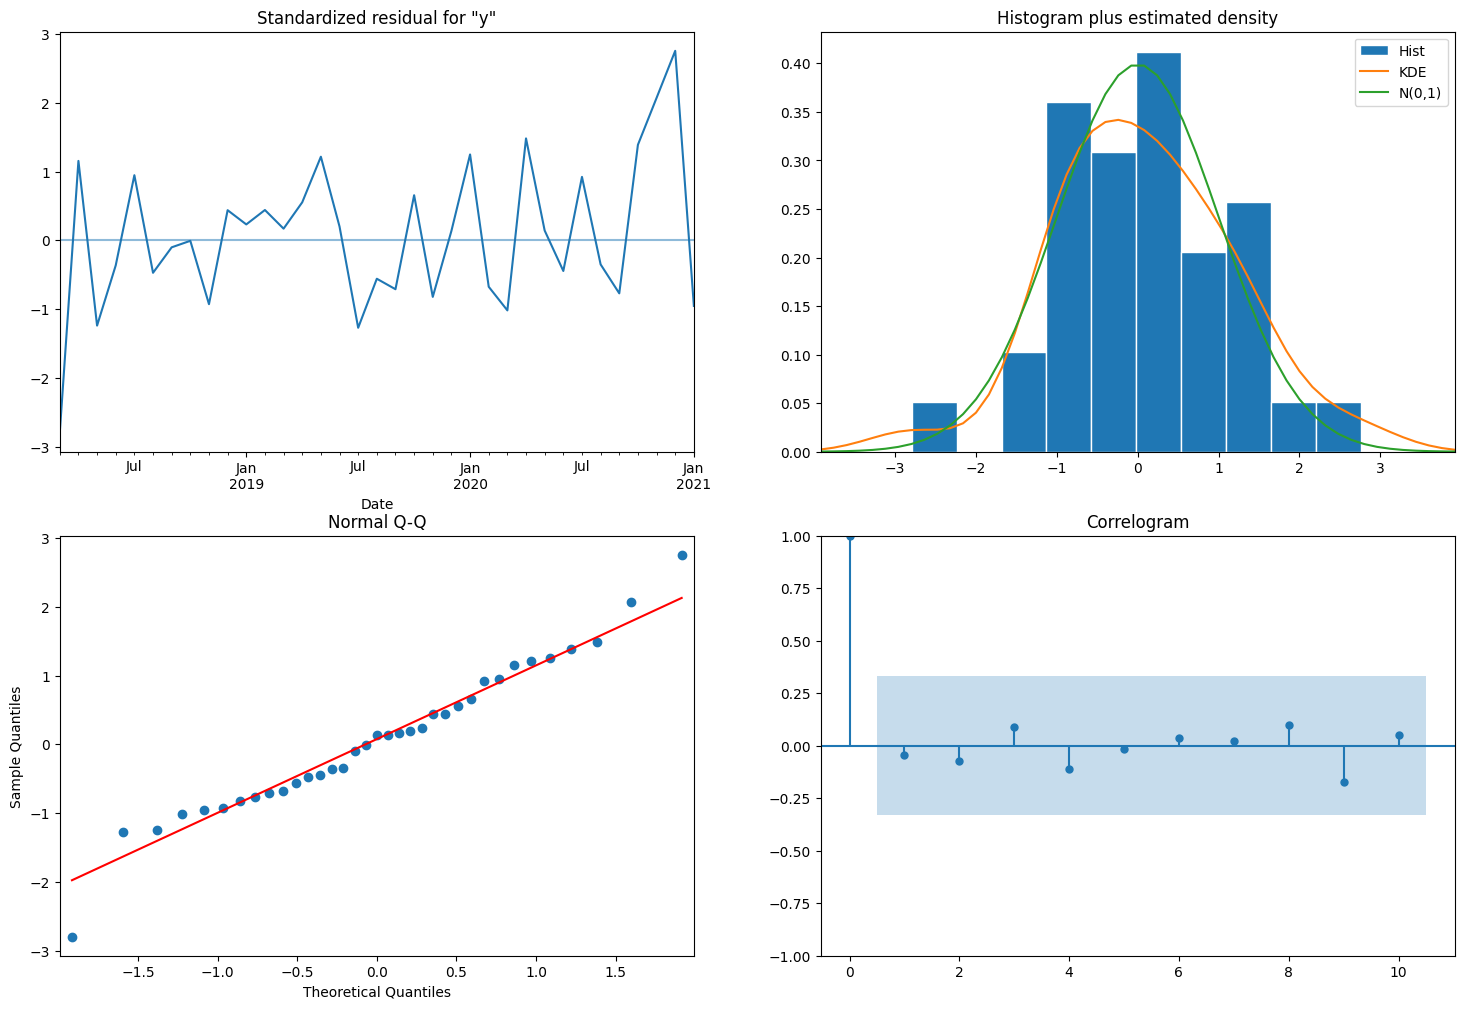

-------------------
PREVISÃO
-------------------


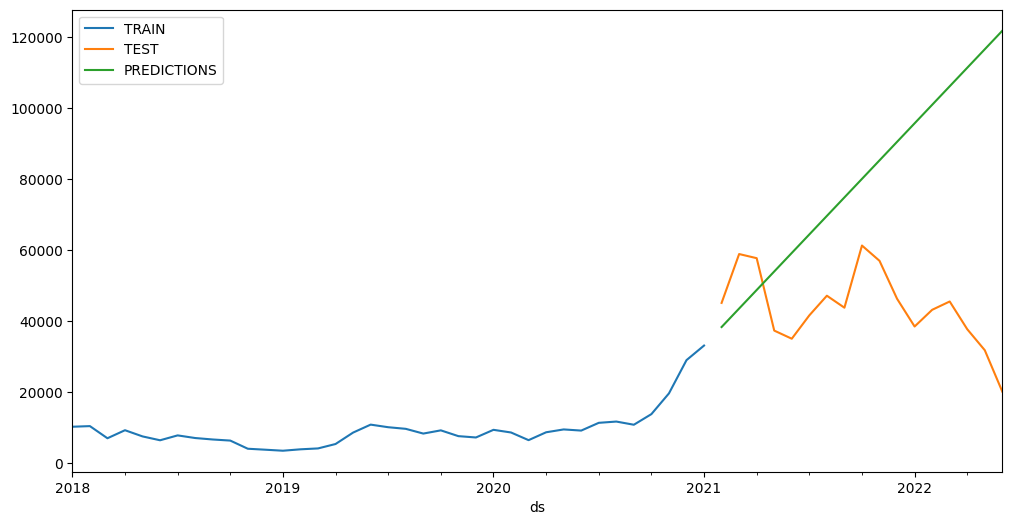

                          model           mse          rmse           mae  \
0  ARIMA(0,2,1)(single_testing)  2.331931e+09  48290.076267  39763.335506   

          r2        mape      smape  
0 -20.772637  112.033675  59.883095  
ARIMA(0,2,1)(incremental_testing)
------------------
MODELO
------------------
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   53
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -515.640
Date:                Tue, 15 Apr 2025   AIC                           1035.281
Time:                        12:35:50   BIC                           1039.144
Sample:                             0   HQIC                          1036.757
                                 - 53                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|    

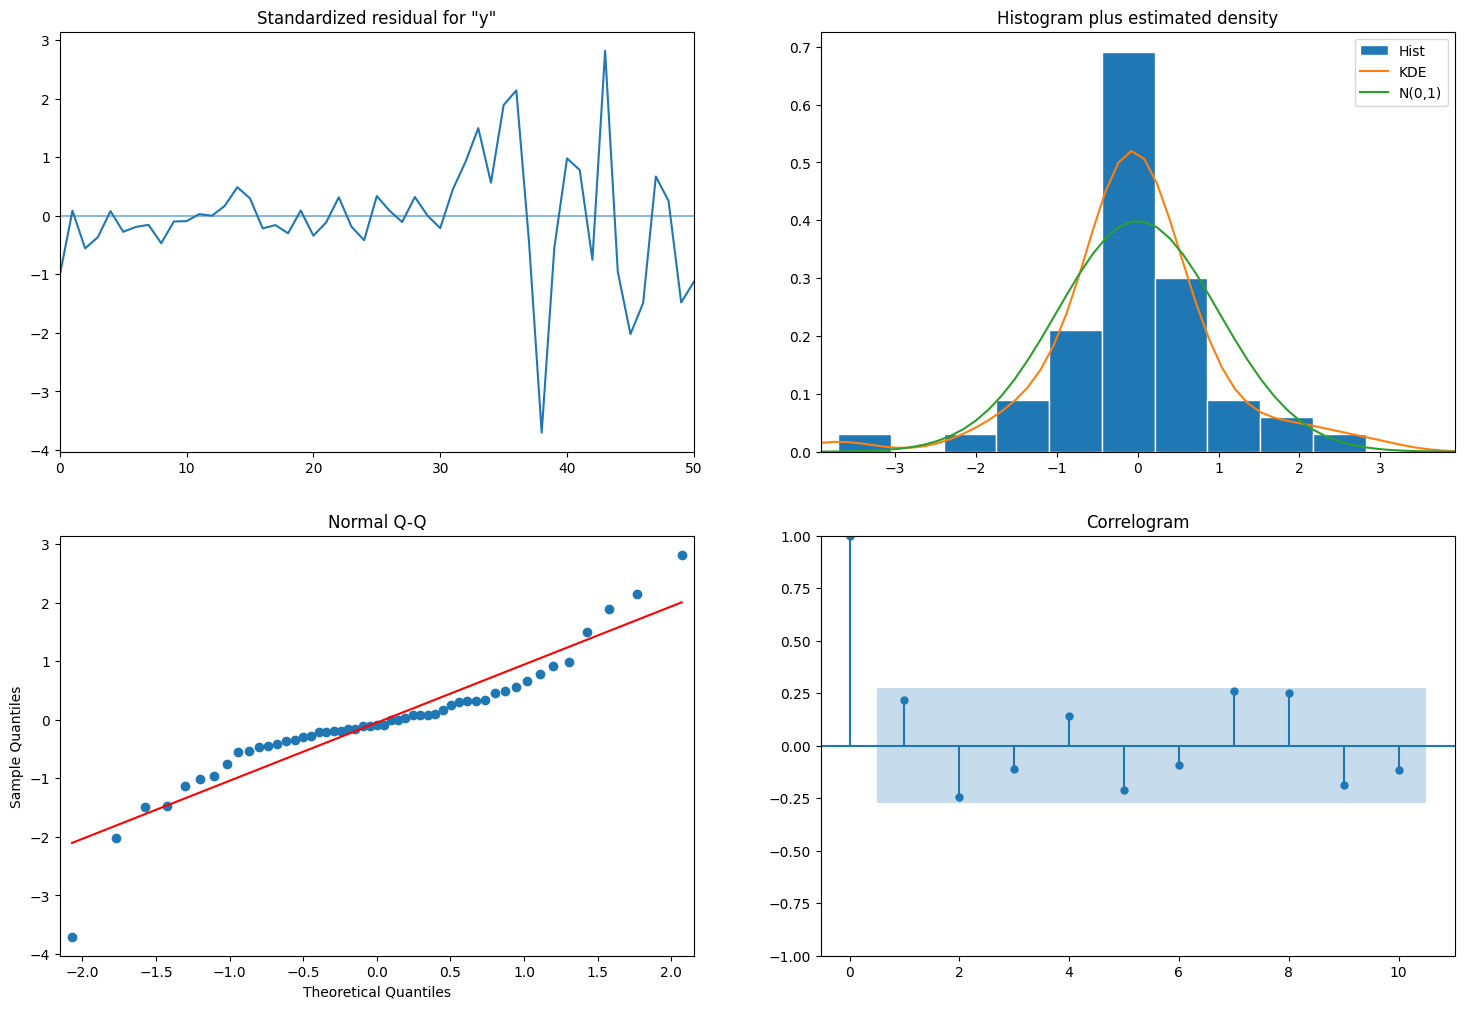

-------------------
PREVISÃO
-------------------


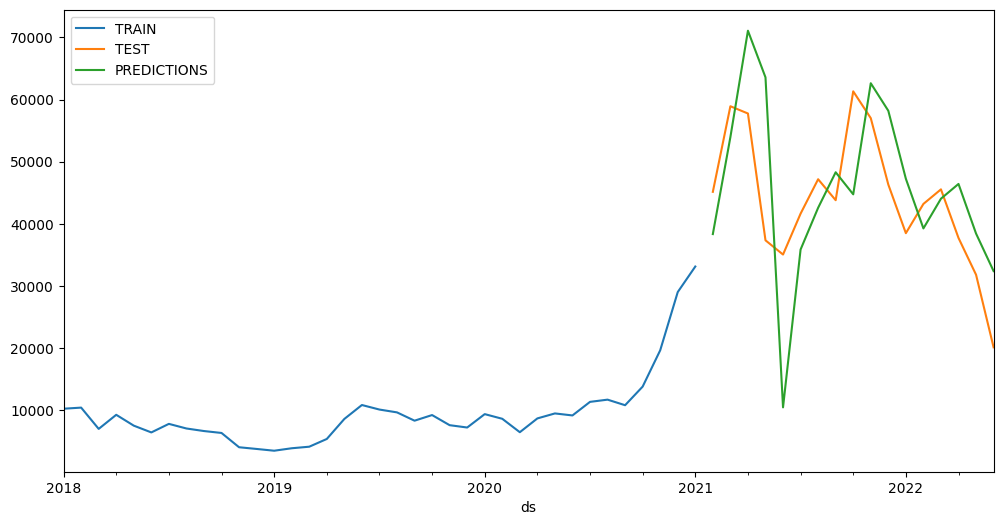

                               model           mse          rmse          mae  \
0  ARIMA(0,2,1)(incremental_testing)  1.429212e+08  11954.966038  9806.289077   

         r2       mape      smape  
0 -0.334418  24.923306  24.942698  


In [ ]:
pred_arima021_met, arima021_met = model_evaluation(train, test, 0, 2, 1)

## ARIMA(1,1,1)

ARIMA(1,1,1)(single_testing)
------------------
MODELO
------------------
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   37
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -327.007
Date:                Tue, 15 Apr 2025   AIC                            660.015
Time:                        12:35:52   BIC                            664.766
Sample:                    01-31-2018   HQIC                           661.673
                         - 01-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1920      0.237     -0.809      0.418      -0.657       0.273
ma.L1          0.7247      0.235      3.086      0.002   

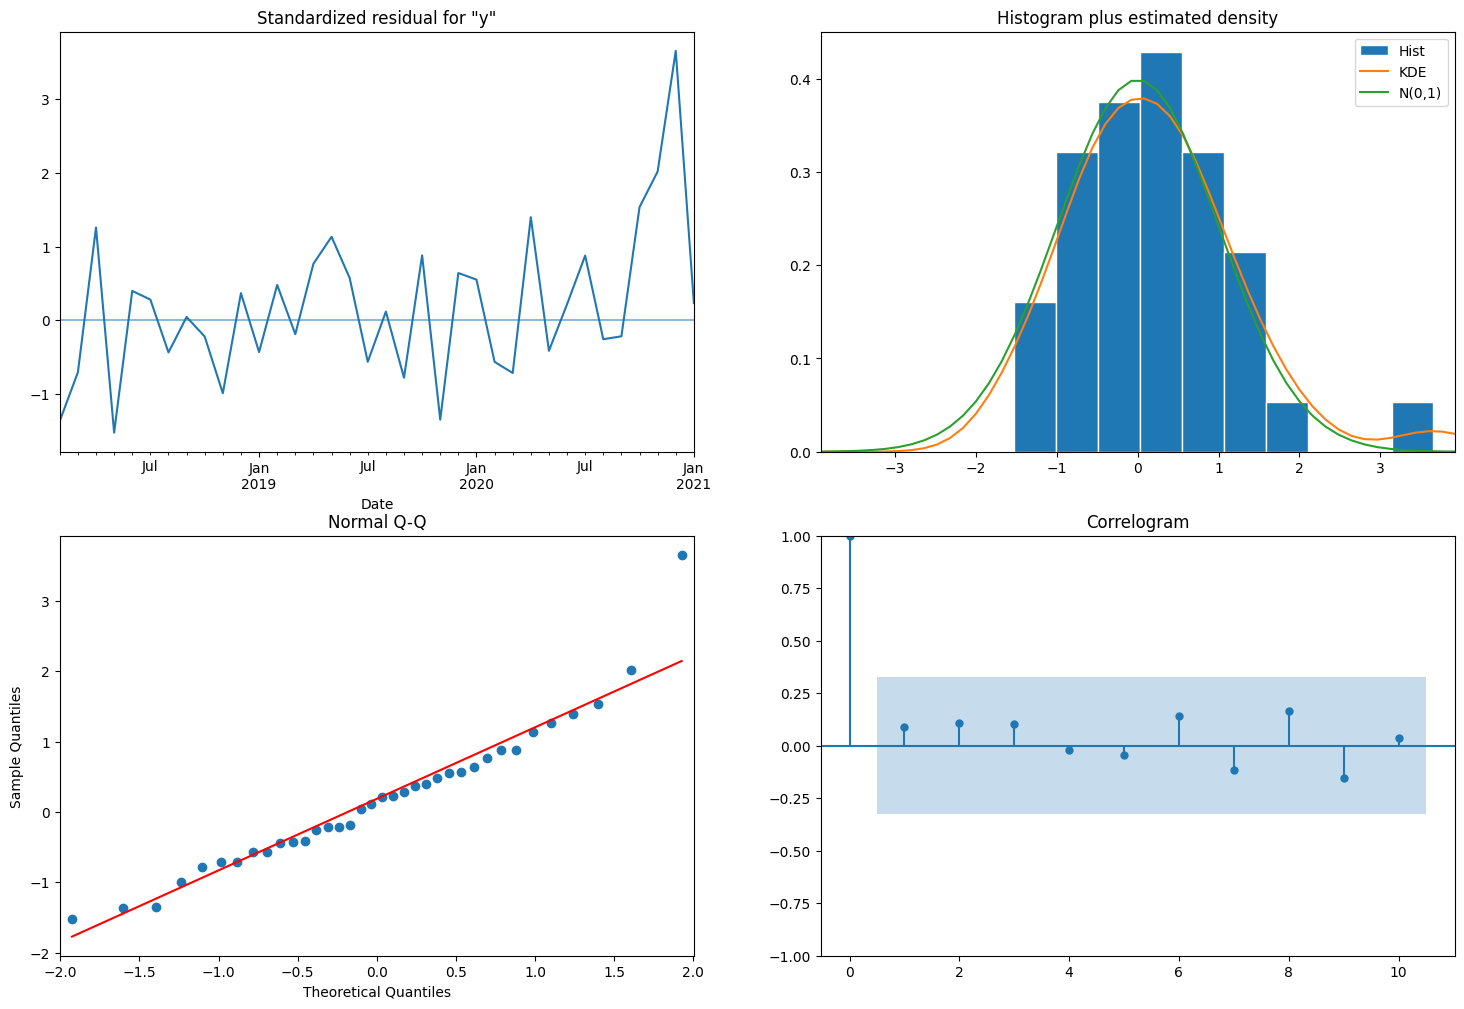

-------------------
PREVISÃO
-------------------


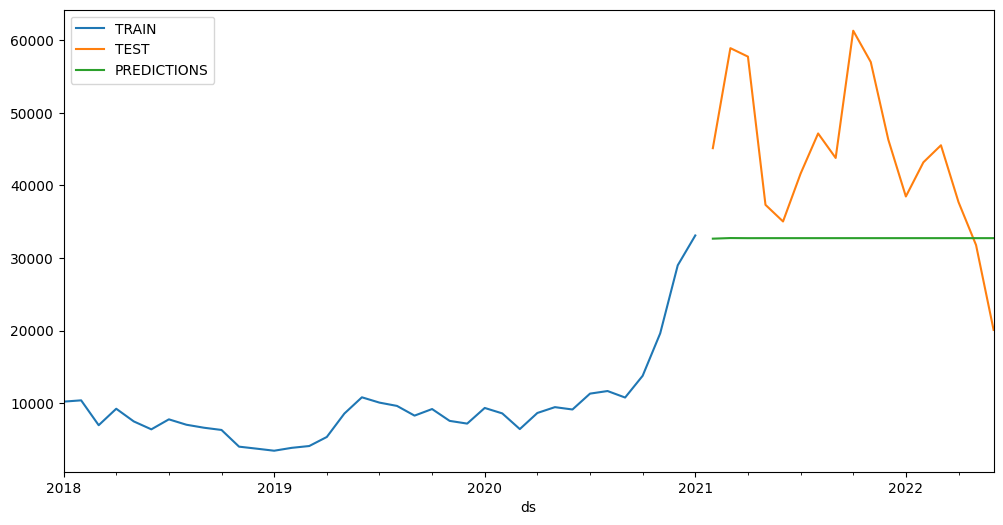

                          model           mse          rmse           mae  \
0  ARIMA(1,1,1)(single_testing)  2.341841e+08  15303.075672  12872.234243   

         r2       mape     smape  
0 -1.186516  28.001752  31.97039  
ARIMA(1,1,1)(incremental_testing)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


------------------
MODELO
------------------
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   53
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -521.048
Date:                Tue, 15 Apr 2025   AIC                           1048.096
Time:                        12:35:53   BIC                           1053.950
Sample:                             0   HQIC                          1050.341
                                 - 53                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1334      0.439     -0.304      0.761      -0.995       0.728
ma.L1          0.4430      0.380      1.165      0.244      -0.302       1.188
sigma2 

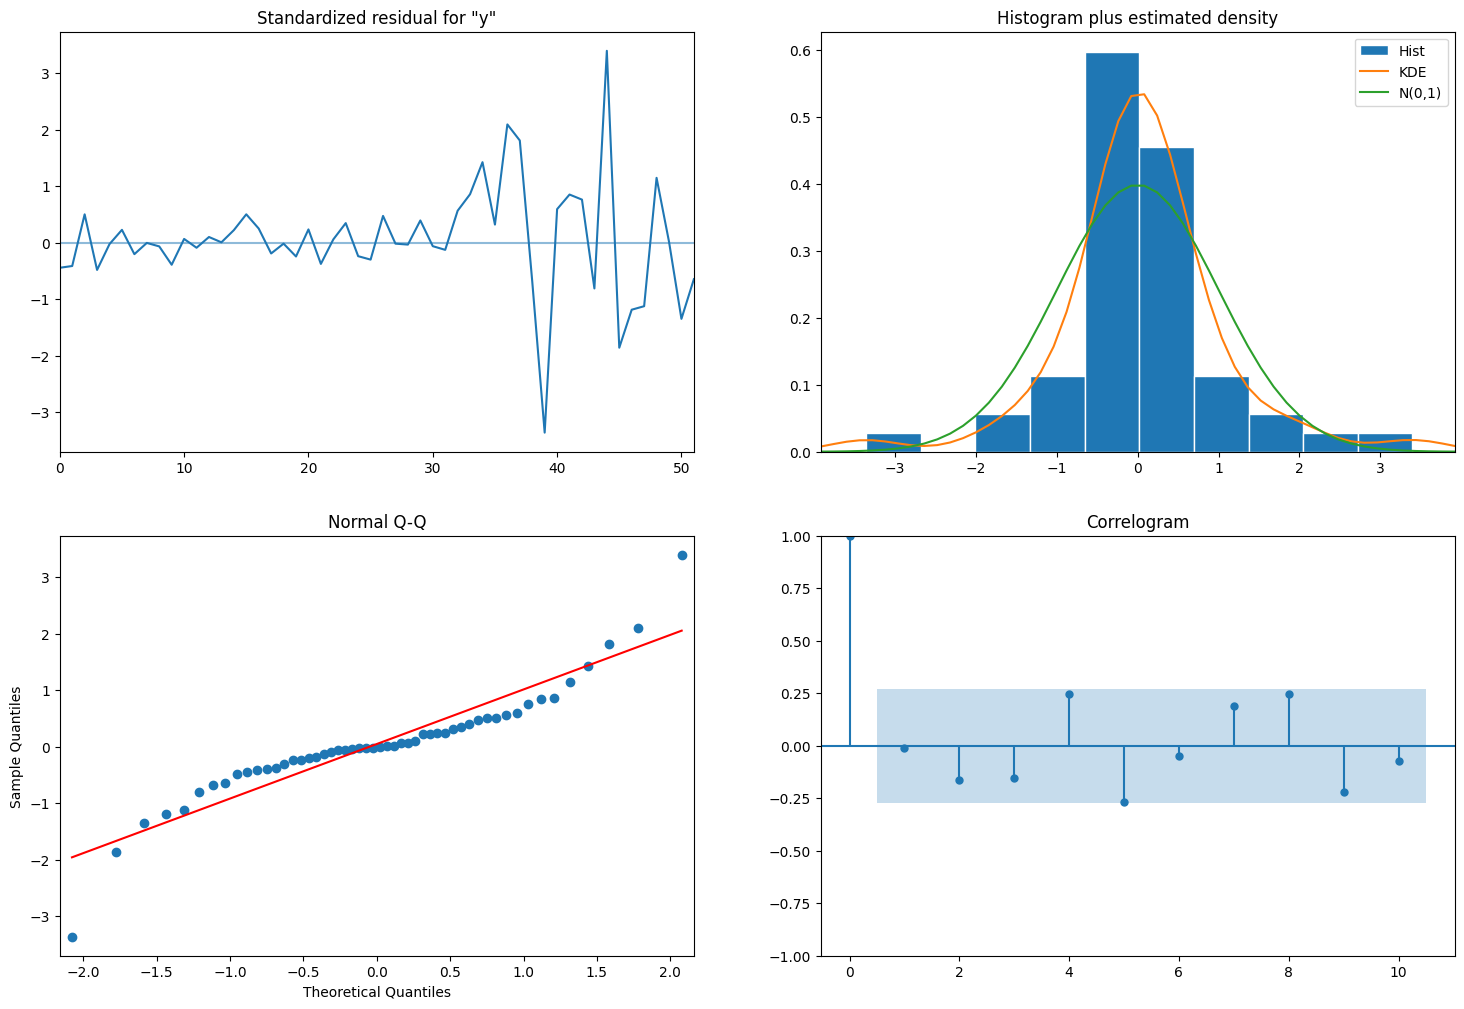

-------------------
PREVISÃO
-------------------


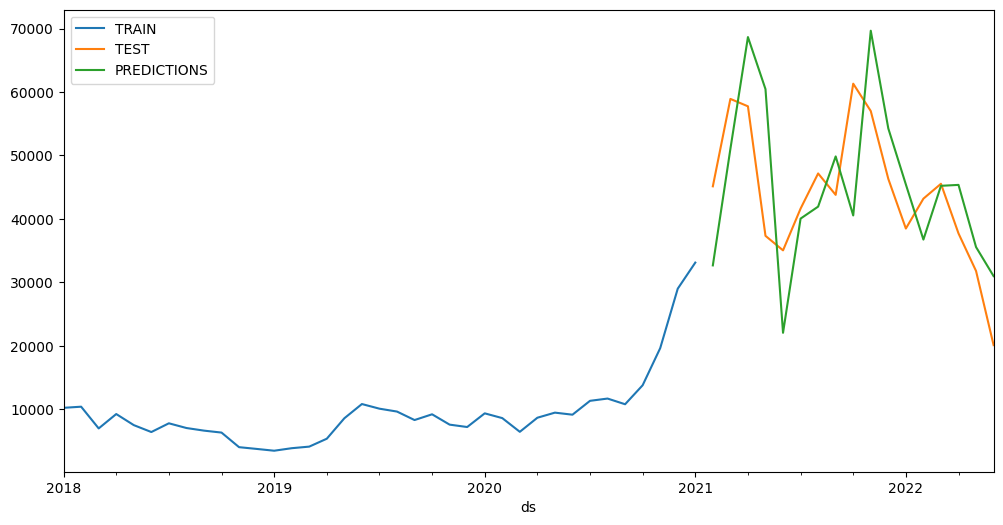

                               model           mse          rmse          mae  \
0  ARIMA(1,1,1)(incremental_testing)  1.201966e+08  10963.420059  9274.470665   

         r2       mape      smape  
0 -0.122244  22.403612  21.601445  


In [ ]:
pred_arima111_met, arima111_met = model_evaluation(train, test, 1, 1, 1)

## ARIMA(1,1,0)

ARIMA(1,1,0)(single_testing)
------------------
MODELO
------------------
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   37
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -329.131
Date:                Tue, 15 Apr 2025   AIC                            662.263
Time:                        12:35:54   BIC                            665.430
Sample:                    01-31-2018   HQIC                           663.368
                         - 01-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3663      0.121      3.024      0.002       0.129       0.604
sigma2      4.901e+06   1.17e+06      4.191      0.000   

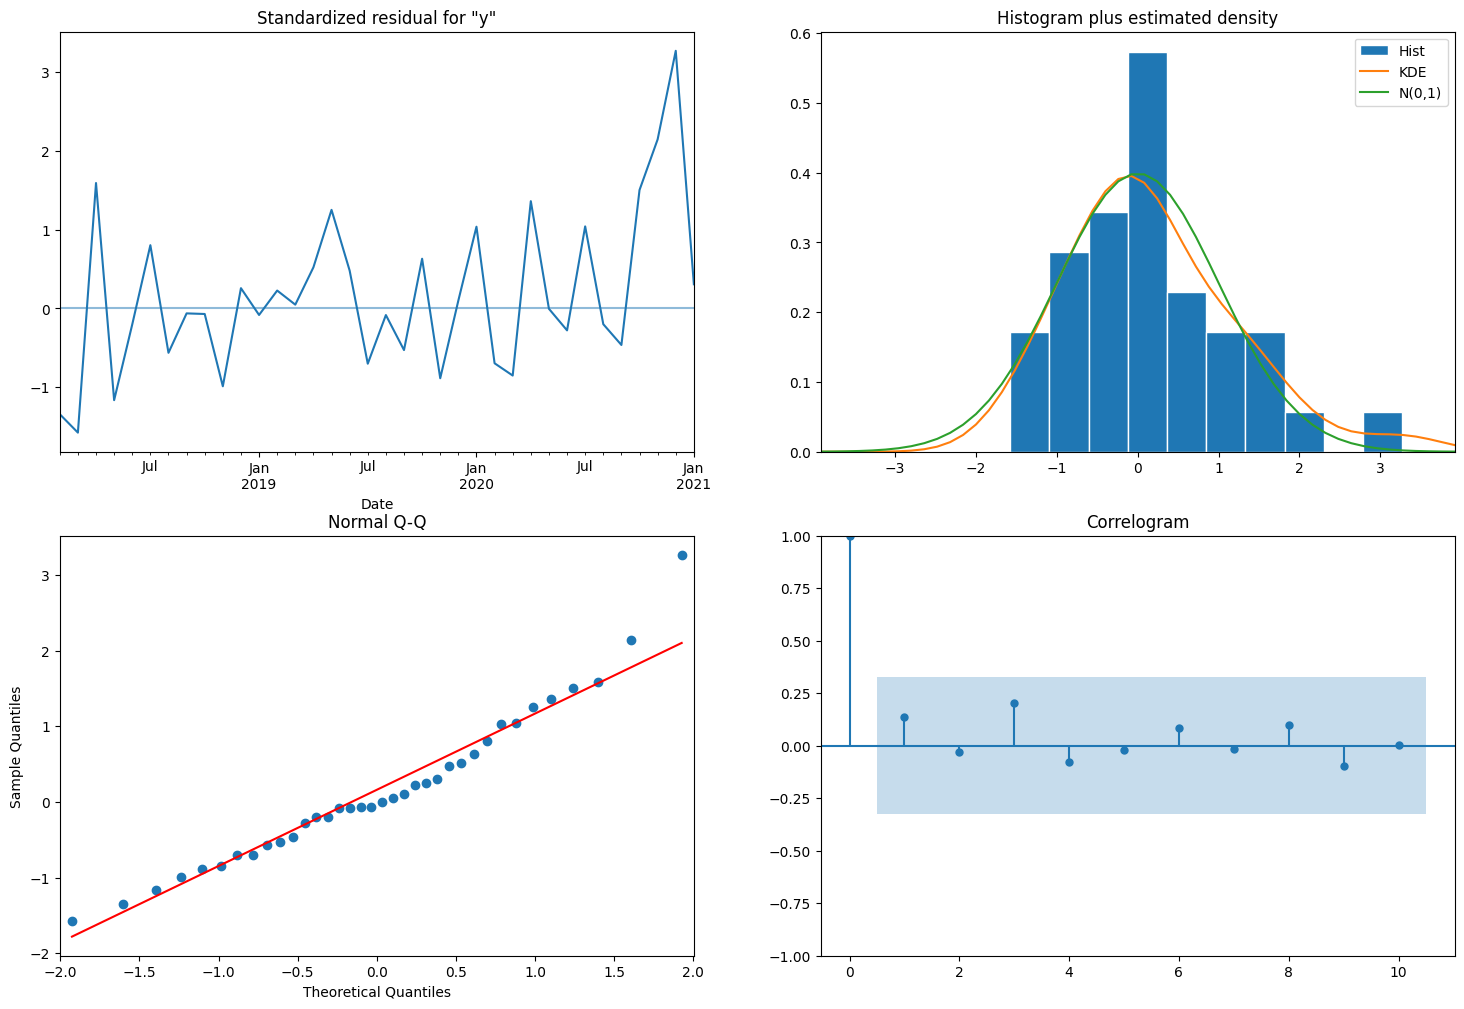

-------------------
PREVISÃO
-------------------


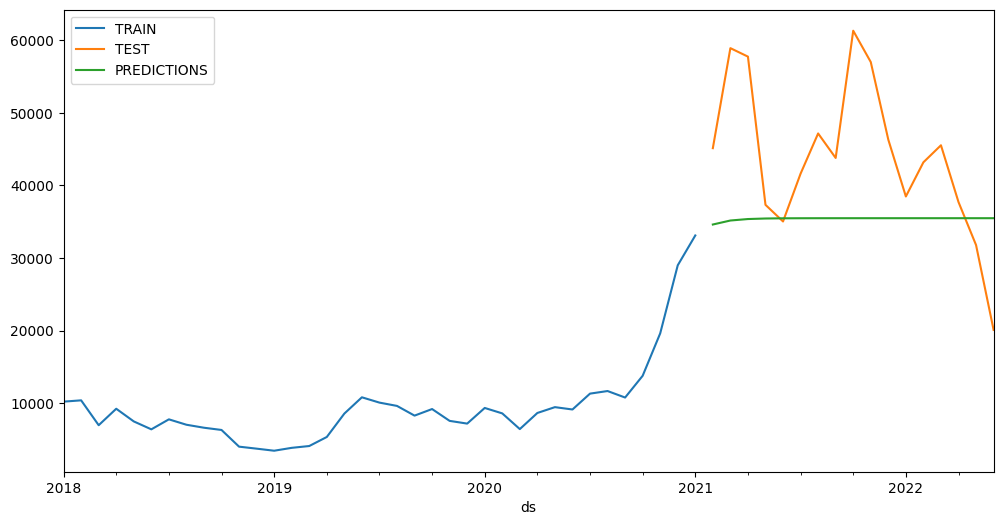

                          model           mse          rmse           mae  \
0  ARIMA(1,1,0)(single_testing)  1.819537e+08  13489.022736  10898.689007   

         r2       mape      smape  
0 -0.698855  24.237874  26.330884  
ARIMA(1,1,0)(incremental_testing)
------------------
MODELO
------------------
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   53
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -522.268
Date:                Tue, 15 Apr 2025   AIC                           1048.536
Time:                        12:35:56   BIC                           1052.438
Sample:                             0   HQIC                          1050.032
                                 - 53                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0

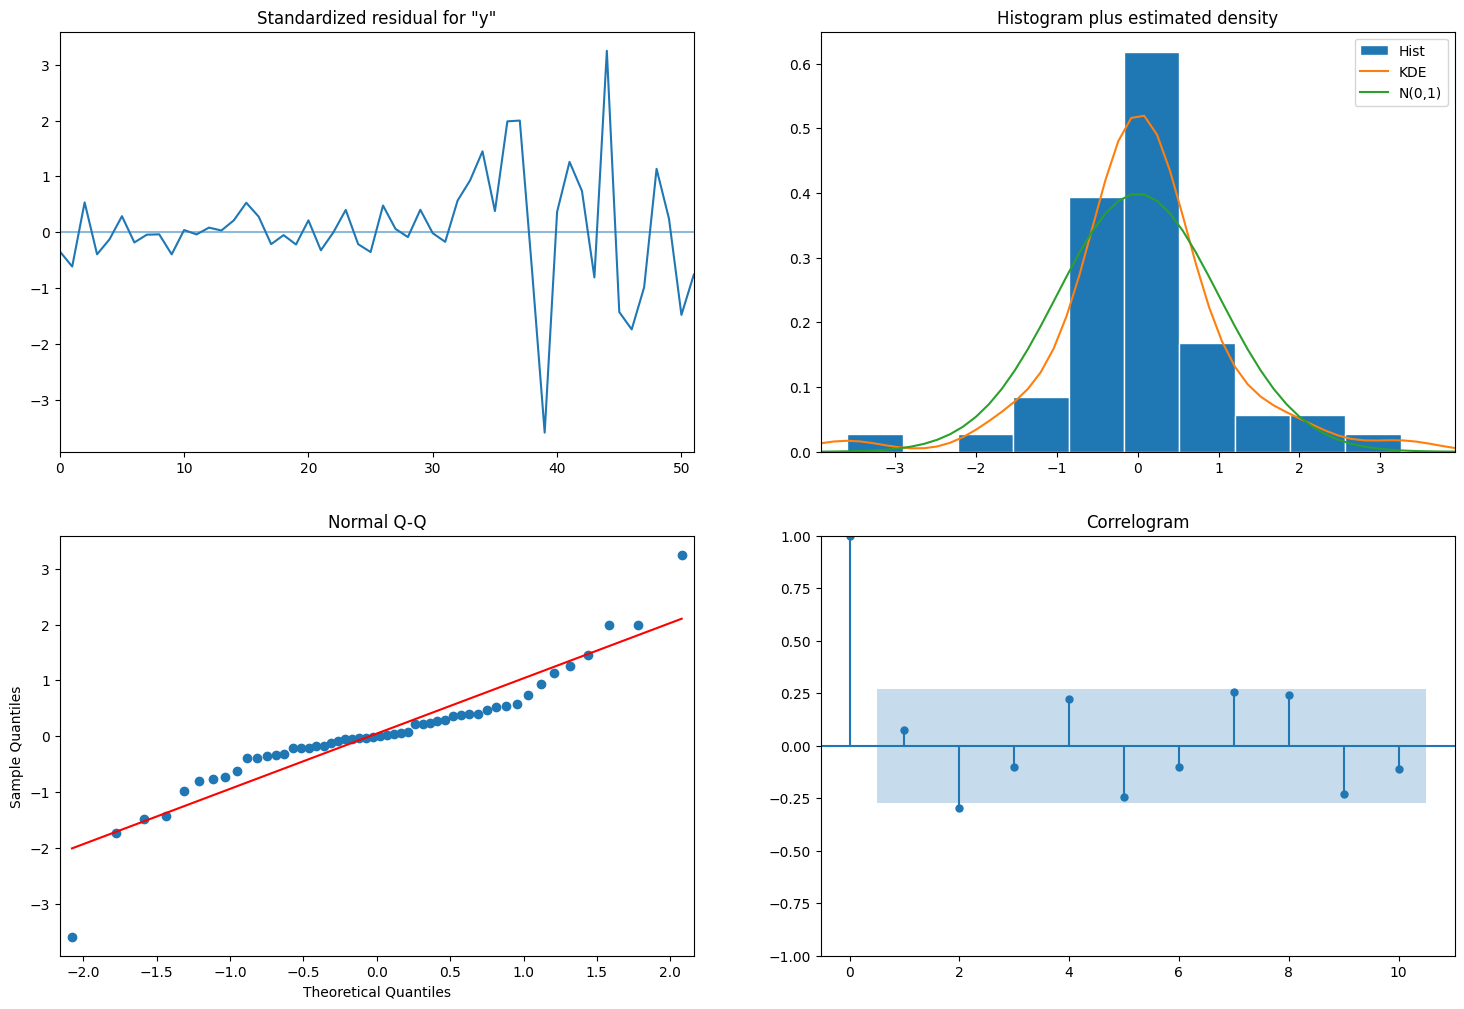

-------------------
PREVISÃO
-------------------


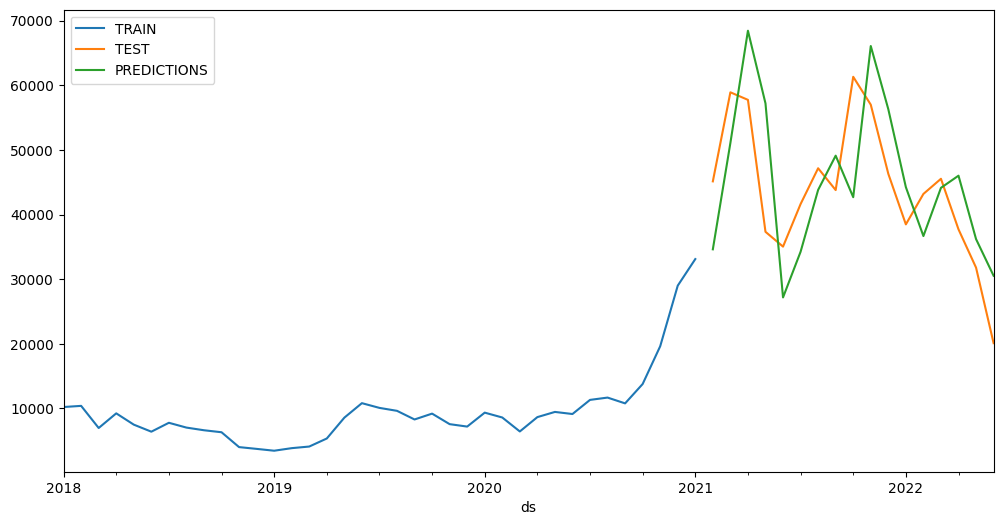

                               model           mse         rmse          mae  \
0  ARIMA(1,1,0)(incremental_testing)  9.655928e+07  9826.458206  8669.295878   

         r2       mape      smape  
0  0.098451  20.976912  20.036849  


In [ ]:
pred_arima110_met, arima110_met = model_evaluation(train, test, 1, 1, 0)

## ARIMA(0,1,1)

ARIMA(0,1,1)(single_testing)
------------------
MODELO
------------------
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   37
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -327.413
Date:                Tue, 15 Apr 2025   AIC                            658.826
Time:                        12:35:57   BIC                            661.994
Sample:                    01-31-2018   HQIC                           659.932
                         - 01-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6291      0.177      3.556      0.000       0.282       0.976
sigma2      4.437e+06   8.79e+05      5.048      0.000   

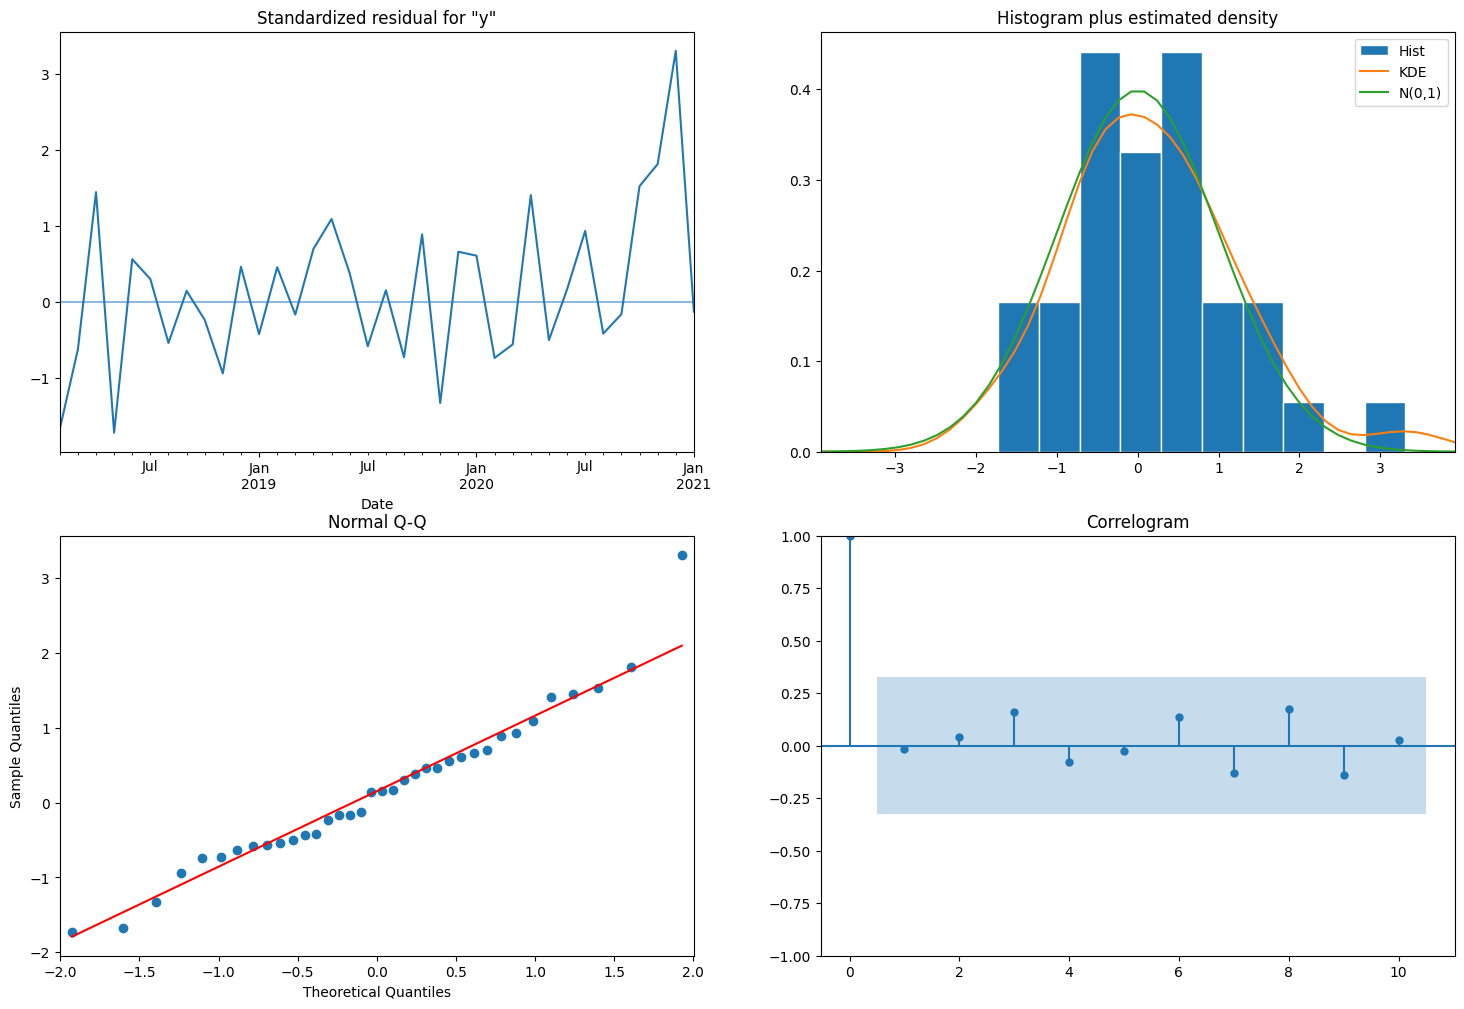

-------------------
PREVISÃO
-------------------


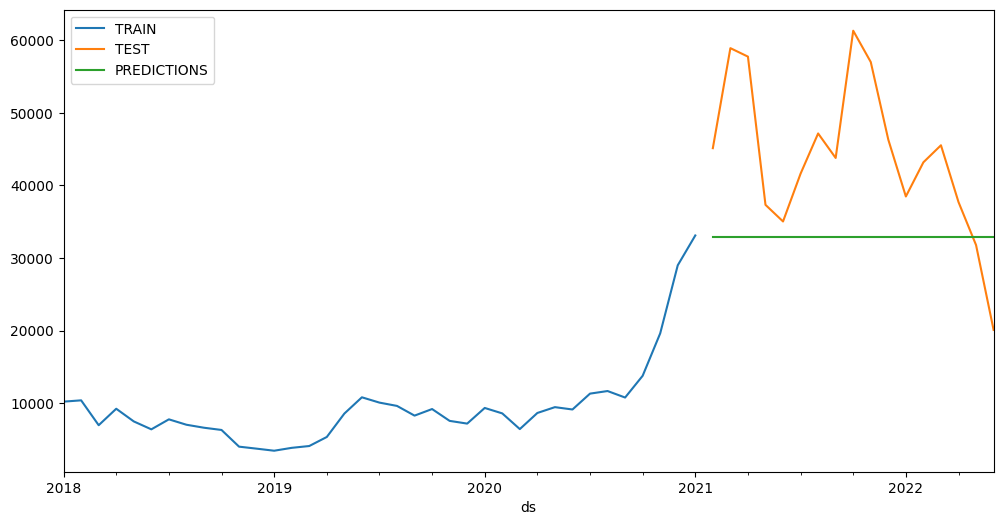

                          model           mse          rmse           mae  \
0  ARIMA(0,1,1)(single_testing)  2.296424e+08  15153.956395  12715.630725   

         r2       mape      smape  
0 -1.144111  27.697242  31.509568  
ARIMA(0,1,1)(incremental_testing)
------------------
MODELO
------------------
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   53
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -521.139
Date:                Tue, 15 Apr 2025   AIC                           1046.277
Time:                        12:35:59   BIC                           1050.180
Sample:                             0   HQIC                          1047.773
                                 - 53                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0

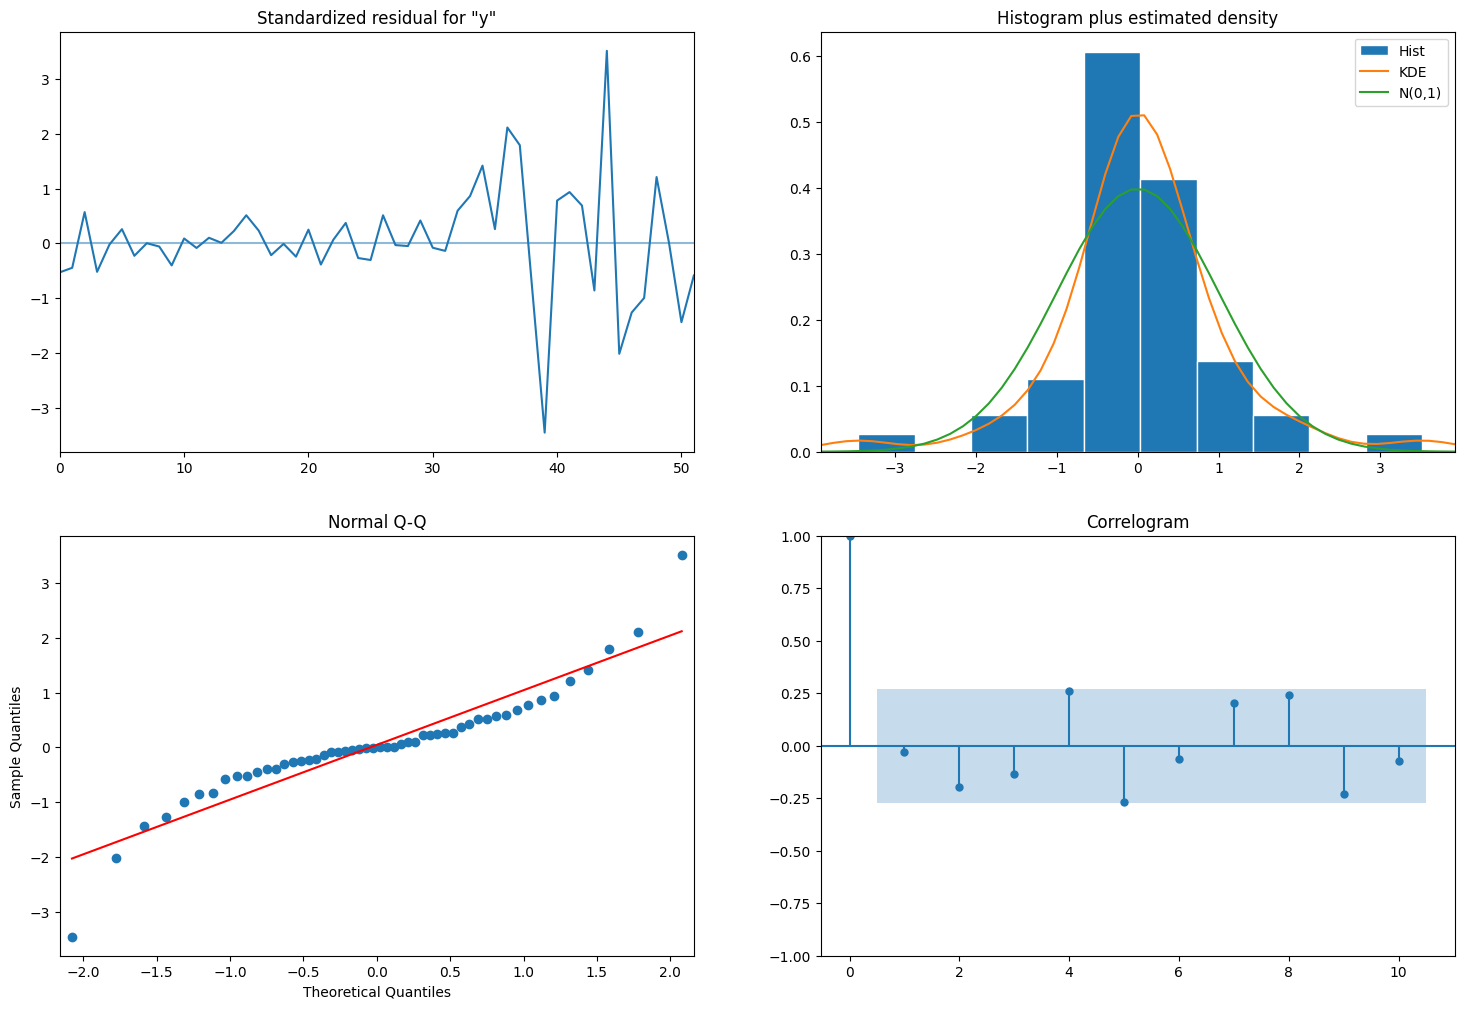

-------------------
PREVISÃO
-------------------


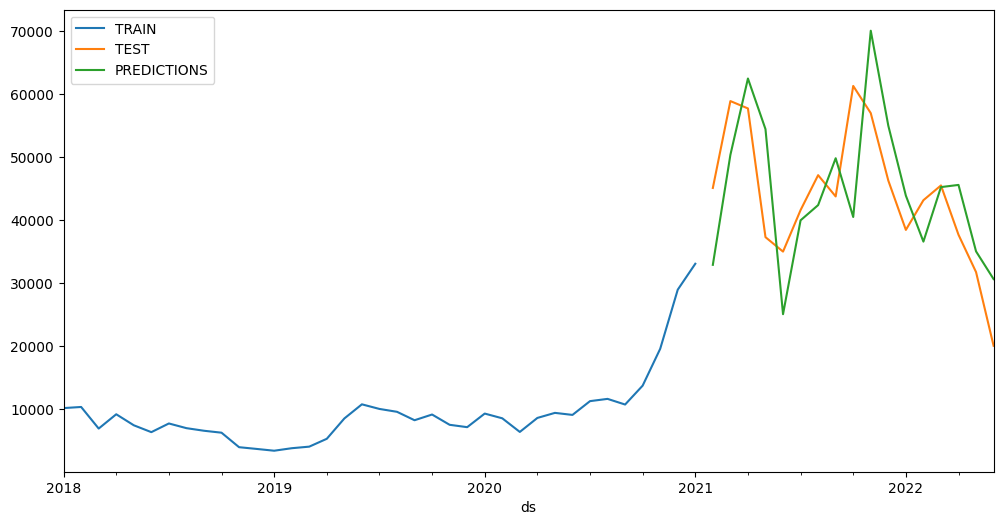

                               model           mse         rmse          mae  \
0  ARIMA(0,1,1)(incremental_testing)  9.616590e+07  9806.421263  8327.302773   

         r2       mape     smape  
0  0.102124  20.069902  19.52066  


In [ ]:
pred_arima011_met, arima011_met = model_evaluation(train, test, 0, 1, 1)

## AutoARIMA


In [ ]:

#Preparando os dados para o formato esperado pelos pacotes do StatsForecast
sf_train = train.reset_index().rename(columns={'Date':'ds'})
sf_train['unique_id'] = ticker
sf_train.head()

Ticker         ds             y unique_id
0      2018-01-31  10221.099609   BTC-USD
1      2018-02-28  10397.900391   BTC-USD
2      2018-03-31   6973.529785   BTC-USD
3      2018-04-30   9240.549805   BTC-USD
4      2018-05-31   7494.169922   BTC-USD

In [ ]:
models = [AutoARIMA()]
sf = StatsForecast(models=models, freq='M')
sf.fit(df=sf_train)
model_str = arima_string(sf.fitted_[0,0].model_)
print(f'Best ARIMA model: {model_str}')

Best ARIMA model: ARIMA(0,2,1)                   


In [ ]:
#import re
## Expressão regular para extrair p, d, q
#match = re.search(r'ARIMA\((\d+),(\d+),(\d+)\)', model_str)
#if match:
#  p, d, q = map(int, match.groups())
#  model_evaluation(train, test, p, d, q)
#else:
#  raise Exception('Erro na identificação dos hiper-parâmetros')

## Best Model

In [ ]:
models_met = pd.concat([arima221_met, arima220_met, arima021_met, arima111_met, arima110_met, arima011_met], axis=0)
models_met

model          aic          bic         hqic  \
0       ARIMA(2,2,1)(single_testing)   640.422077   646.643469   642.569701   
0  ARIMA(2,2,1)(incremental_testing)  1031.927619  1039.654922  1034.880450   
0       ARIMA(2,2,0)(single_testing)   640.521302   645.187346   642.132020   
0  ARIMA(2,2,0)(incremental_testing)  1042.155248  1047.950725  1044.369871   
0       ARIMA(0,2,1)(single_testing)   646.122379   649.233075   647.196191   
0  ARIMA(0,2,1)(incremental_testing)  1035.280530  1039.144181  1036.756945   
0       ARIMA(1,1,1)(single_testing)   660.014982   664.765539   661.673054   
0  ARIMA(1,1,1)(incremental_testing)  1048.096324  1053.950055  1050.340507   
0       ARIMA(1,1,0)(single_testing)   662.262649   665.429687   663.368030   
0  ARIMA(1,1,0)(incremental_testing)  1048.535838  1052.438325  1050.031959   
0       ARIMA(0,1,1)(single_testing)   658.826474   661.993511   659.931855   
0  ARIMA(0,1,1)(incremental_testing)  1046.277371  1050.179859  1047.773493   

          llf  
0 -316.211038  
0 -511.963810  
0 -317.260651  
0 -518.077624  
0 -321.061189  
0 -515.640265  
0 -327.007491  
0 -521.048162  
0 -329.131324  
0 -522.267919  
0 -327.413237  
0 -521.138686

### Single Training

In [ ]:
models_met_single = models_met[models_met['model'].str.contains('single')]
models_met_single = rank_models(models_met_single)
models_met_single[models_met_single['final_rank']<=3]

model         aic         bic        hqic  \
0  ARIMA(2,2,1)(single_testing)  640.422077  646.643469  642.569701   
1  ARIMA(2,2,0)(single_testing)  640.521302  645.187346  642.132020   
2  ARIMA(0,2,1)(single_testing)  646.122379  649.233075  647.196191   

          llf  rank_aic  rank_bic  rank_hqic  rank_llf  final_rank  
0 -316.211038       1.0       2.0        2.0       1.0         1.0  
1 -317.260651       2.0       1.0        1.0       2.0         1.0  
2 -321.061189       3.0       3.0        3.0       3.0         3.0

### Incremental Training

In [ ]:
models_met_inc = models_met[models_met['model'].str.contains('inc')]
models_met_inc = rank_models(models_met_inc)
models_met_inc[models_met_inc['final_rank']<=3]

model          aic          bic         hqic  \
0  ARIMA(2,2,1)(incremental_testing)  1031.927619  1039.654922  1034.880450   
1  ARIMA(0,2,1)(incremental_testing)  1035.280530  1039.144181  1036.756945   
2  ARIMA(2,2,0)(incremental_testing)  1042.155248  1047.950725  1044.369871   

          llf  rank_aic  rank_bic  rank_hqic  rank_llf  final_rank  
0 -511.963810       1.0       2.0        1.0       1.0         1.0  
1 -515.640265       2.0       1.0        2.0       2.0         2.0  
2 -518.077624       3.0       3.0        3.0       3.0         3.0

### In Both Training

In [ ]:
models_met = rank_models(models_met)
#models_met.drop(columns={col for col in models_met.columns if col.startswith('rank_')}, inplace=True)
models_met[models_met['final_rank']<=3]

model         aic         bic        hqic  \
0  ARIMA(2,2,1)(single_testing)  640.422077  646.643469  642.569701   
1  ARIMA(2,2,0)(single_testing)  640.521302  645.187346  642.132020   
2  ARIMA(0,2,1)(single_testing)  646.122379  649.233075  647.196191   

          llf  rank_aic  rank_bic  rank_hqic  rank_llf  final_rank  
0 -316.211038       1.0       2.0        2.0       1.0         1.0  
1 -317.260651       2.0       1.0        1.0       2.0         1.0  
2 -321.061189       3.0       3.0        3.0       3.0         3.0

## Conclusion

### Single Training

No contexto dos treinamentos únicos, a média dos resíduos ajustados dos modelos com 1 diferenciação foram mais distantes do zero do que a dos modelos com 2 diferenciações.

Os modelos com 1 diferenciação também apresentaram AIC e BIC priores do que os dos modelos com 2 diferenciações, confirmando que não houve superdiferenciação.

Em termos de ajuste, o melhor modelo foi o ARIMA(2,2,1), pois teve o menor AIC, BIC e HQIC, além de melhor log-likelihood e resíduos sem autocorrelação (Ljung-Box p = 0.37).

Por outro lado, o modelo automaticamente inferido (Auto_ARIMA(0,2,1)) destacou-se nos testes estatísticos de normalidade, apresentando melhor estatística de Jarque-Bera, skew mais próximo de zero e menor heterocedasticidade. Contudo, visualmente, o histograma dos resíduos do modelo ARIMA(2,2,1) se mostrou mais próximo da distribuição normal..

Além disso, a média do resíduo do modelo ARIMA(2,2,1) foi a mais próxima do zero.

Como o foco é a previsão com menor erro de ajuste, será escolhido o modelo ARIMA(2,2,1), deixando a cargo do modelo GARH o controle da heterocedasticidade dos resíduos, o que será feito em outra lista de exercício.

### Incremental Training

No contexto dos treinamentos incrementais, observou-se uma piora na qualidade dos resíduos em comparação com os experimentos com treinamento único. Isso leva à conclusão de que, nesse tipo de abordagem, a cada nova rodada de treinamento, seria recomendável realizar uma nova análise dos gráficos de ACF e PACF, a fim de verificar se os hiperparâmetros continuam adequados à dinâmica da série naquele momento.

# Modelo AR

## AR(1)

AR(1)(single_testing)
------------------
MODELO
------------------
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   37
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -343.400
Date:                Tue, 15 Apr 2025   AIC                            692.801
Time:                        12:36:01   BIC                            697.634
Sample:                    01-31-2018   HQIC                           694.505
                         - 01-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9609.5558   2.52e+04      0.381      0.703   -3.98e+04     5.9e+04
ar.L1          0.9829      0.029     33.505      0.000       0.9

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


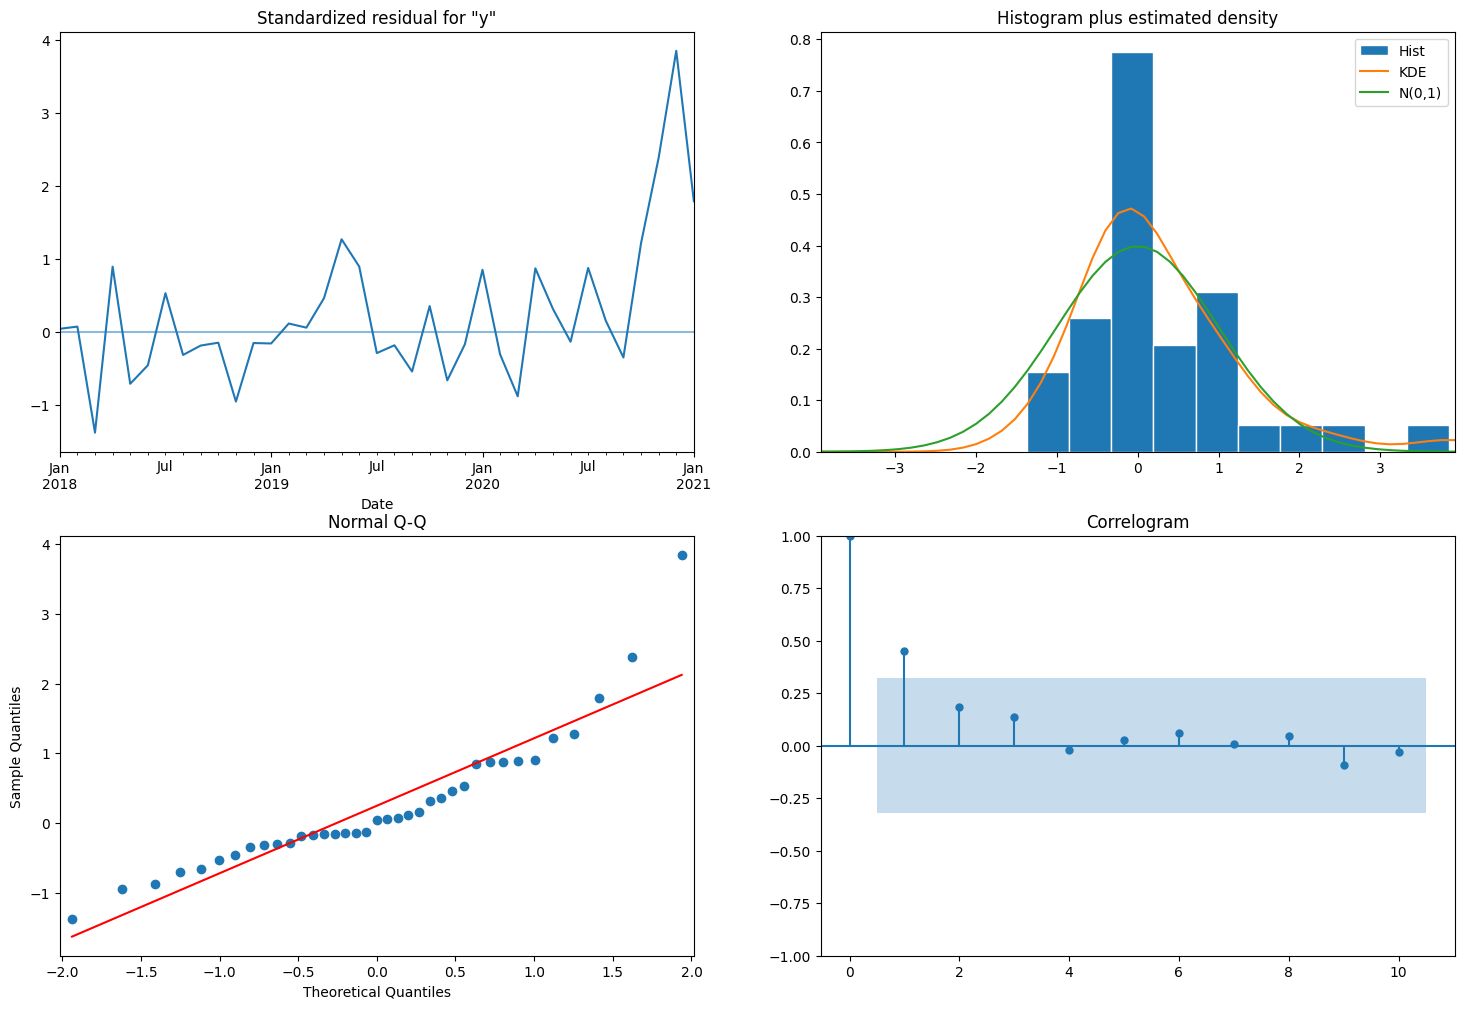

-------------------
PREVISÃO
-------------------


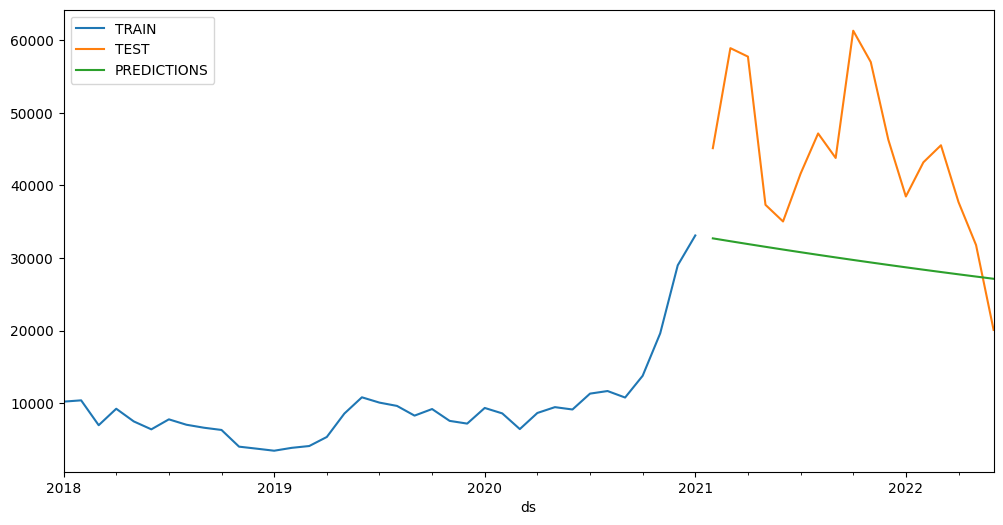

                   model           mse          rmse          mae        r2  \
0  AR(1)(single_testing)  2.944452e+08  17159.406827  15031.91076 -1.749159   

        mape      smape  
0  32.169834  38.712385  
AR(1)(incremental_testing)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


------------------
MODELO
------------------
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   53
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -533.720
Date:                Tue, 15 Apr 2025   AIC                           1073.440
Time:                        12:36:02   BIC                           1079.350
Sample:                             0   HQIC                          1075.713
                                 - 53                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.044e+04   2.07e+04      0.986      0.324   -2.02e+04    6.11e+04
ar.L1          0.9408      0.053     17.652      0.000       0.836       1.045
sigma2 

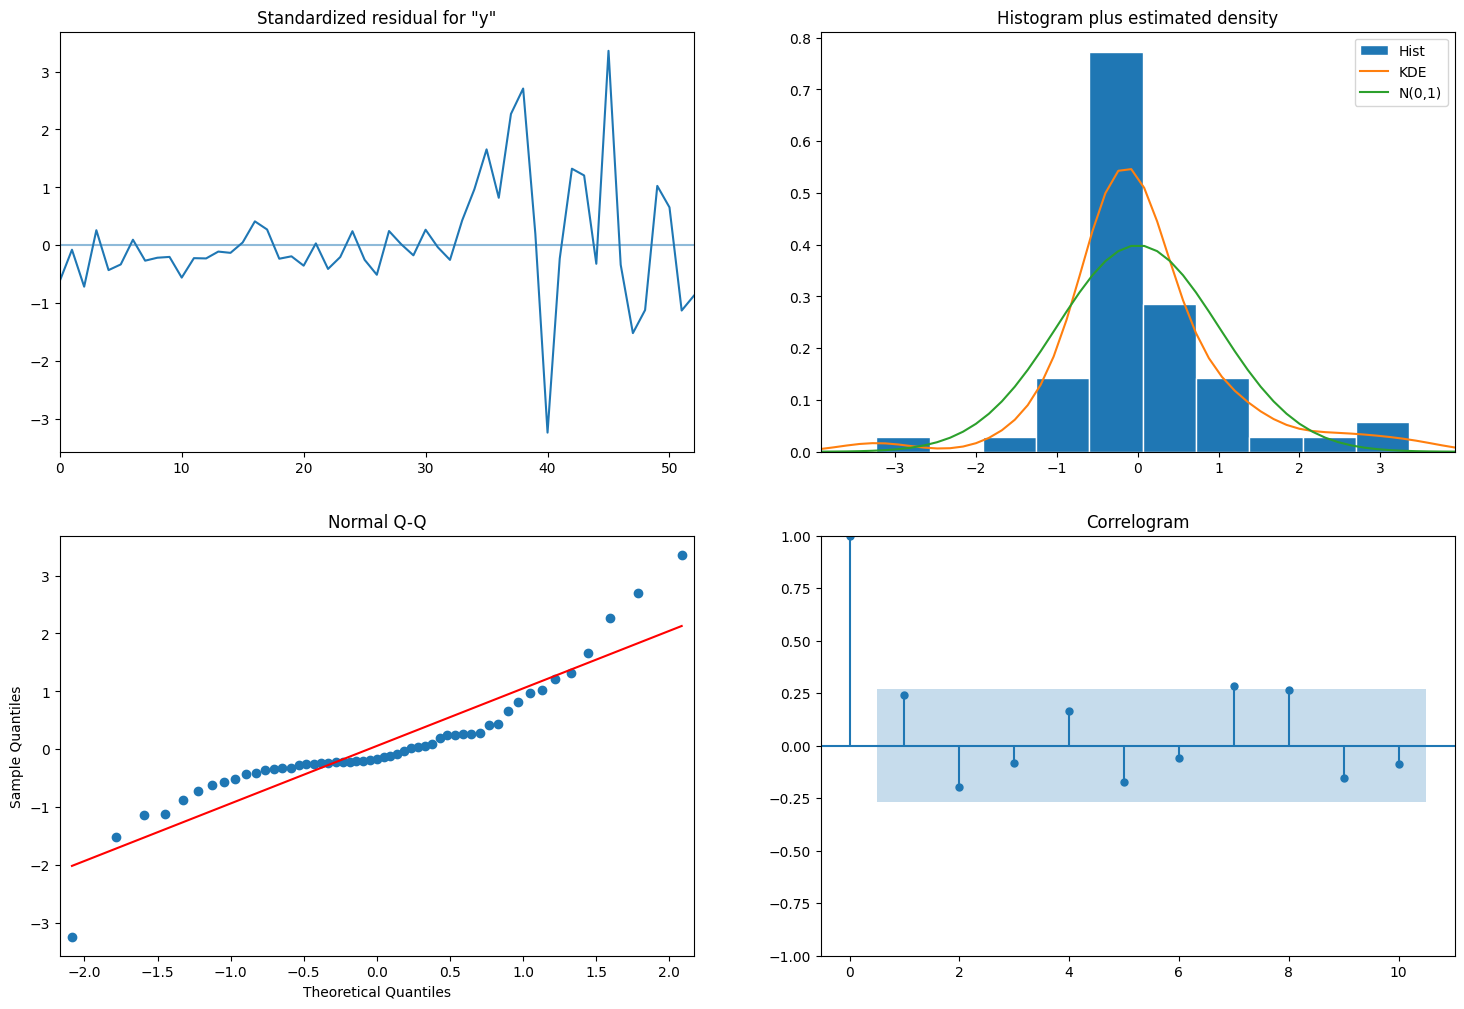

-------------------
PREVISÃO
-------------------


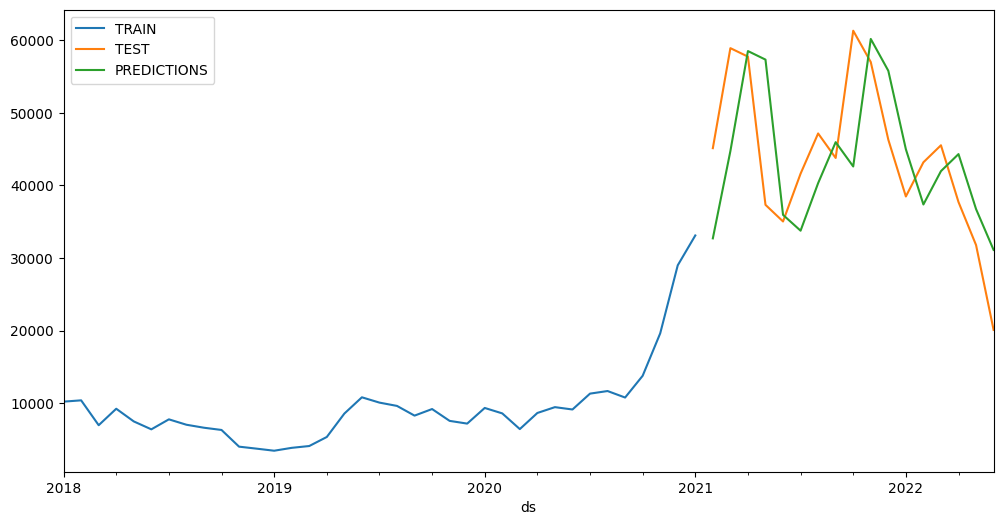

                        model           mse         rmse          mae  \
0  AR(1)(incremental_testing)  9.404463e+07  9697.660948  7941.250942   

        r2       mape     smape  
0  0.12193  19.419699  18.73586  


In [ ]:
pred_ar1_met, ar1_met = model_evaluation(train, test, 1, 0, 0)

## AR(2)

AR(2)(single_testing)
------------------
MODELO
------------------
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   37
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -338.528
Date:                Tue, 15 Apr 2025   AIC                            685.056
Time:                        12:36:03   BIC                            691.499
Sample:                    01-31-2018   HQIC                           687.327
                         - 01-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9603.8883   8737.100      1.099      0.272   -7520.512    2.67e+04
ar.L1          1.4737      0.132     11.134      0.000       1.2

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


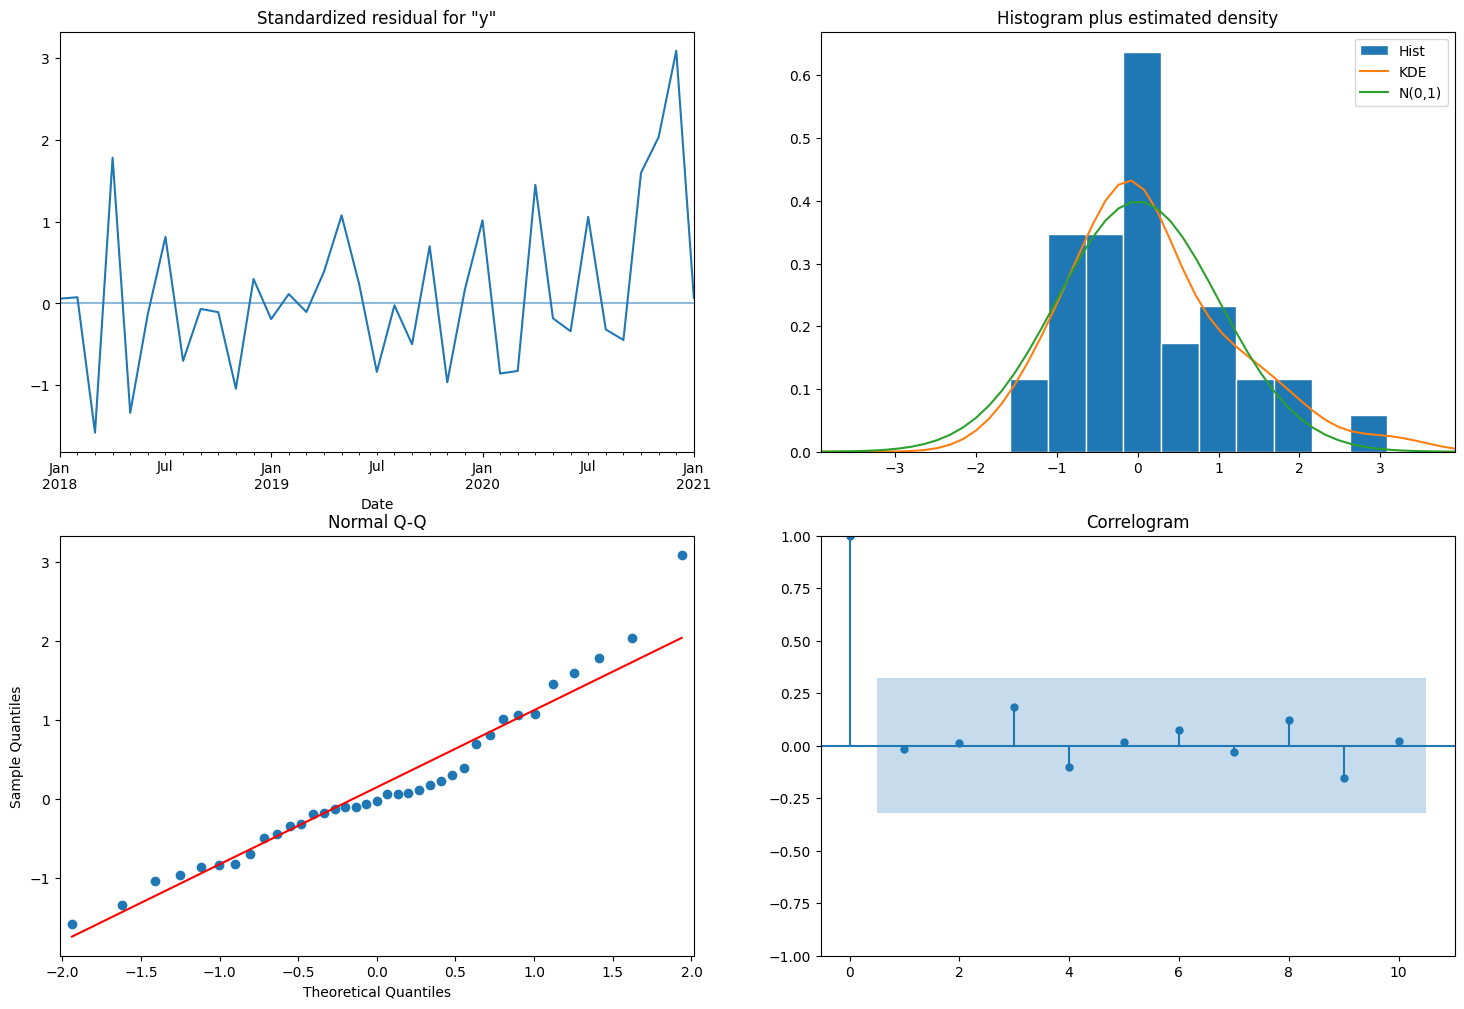

-------------------
PREVISÃO
-------------------


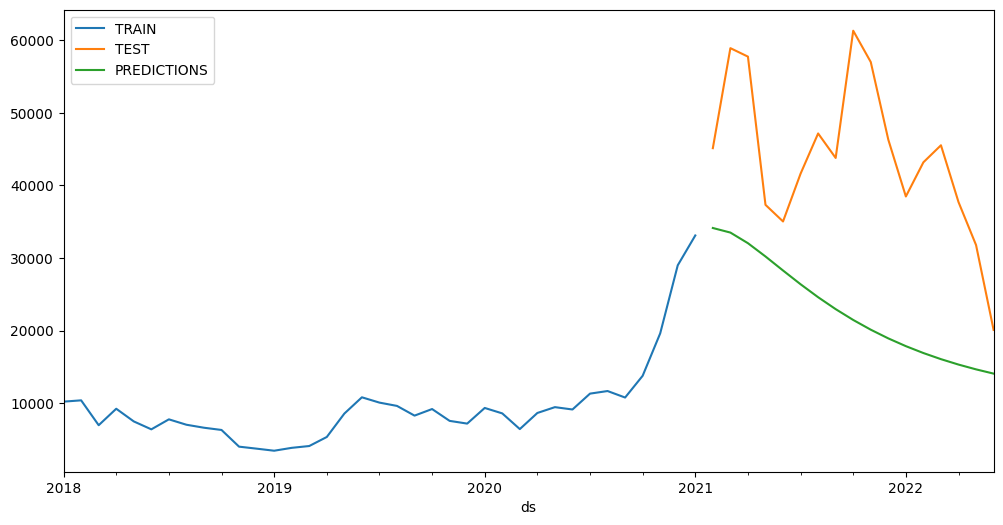

                   model           mse         rmse           mae        r2  \
0  AR(2)(single_testing)  5.417684e+08  23275.91983  21211.858499 -4.058351   

        mape      smape  
0  46.672364  63.405439  
AR(2)(incremental_testing)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


------------------
MODELO
------------------
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   53
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -531.999
Date:                Tue, 15 Apr 2025   AIC                           1071.999
Time:                        12:36:05   BIC                           1079.880
Sample:                             0   HQIC                          1075.030
                                 - 53                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.044e+04   1.81e+04      1.132      0.258    -1.5e+04    5.59e+04
ar.L1          1.1802      0.137      8.613      0.000       0.912       1.449
ar.L2  

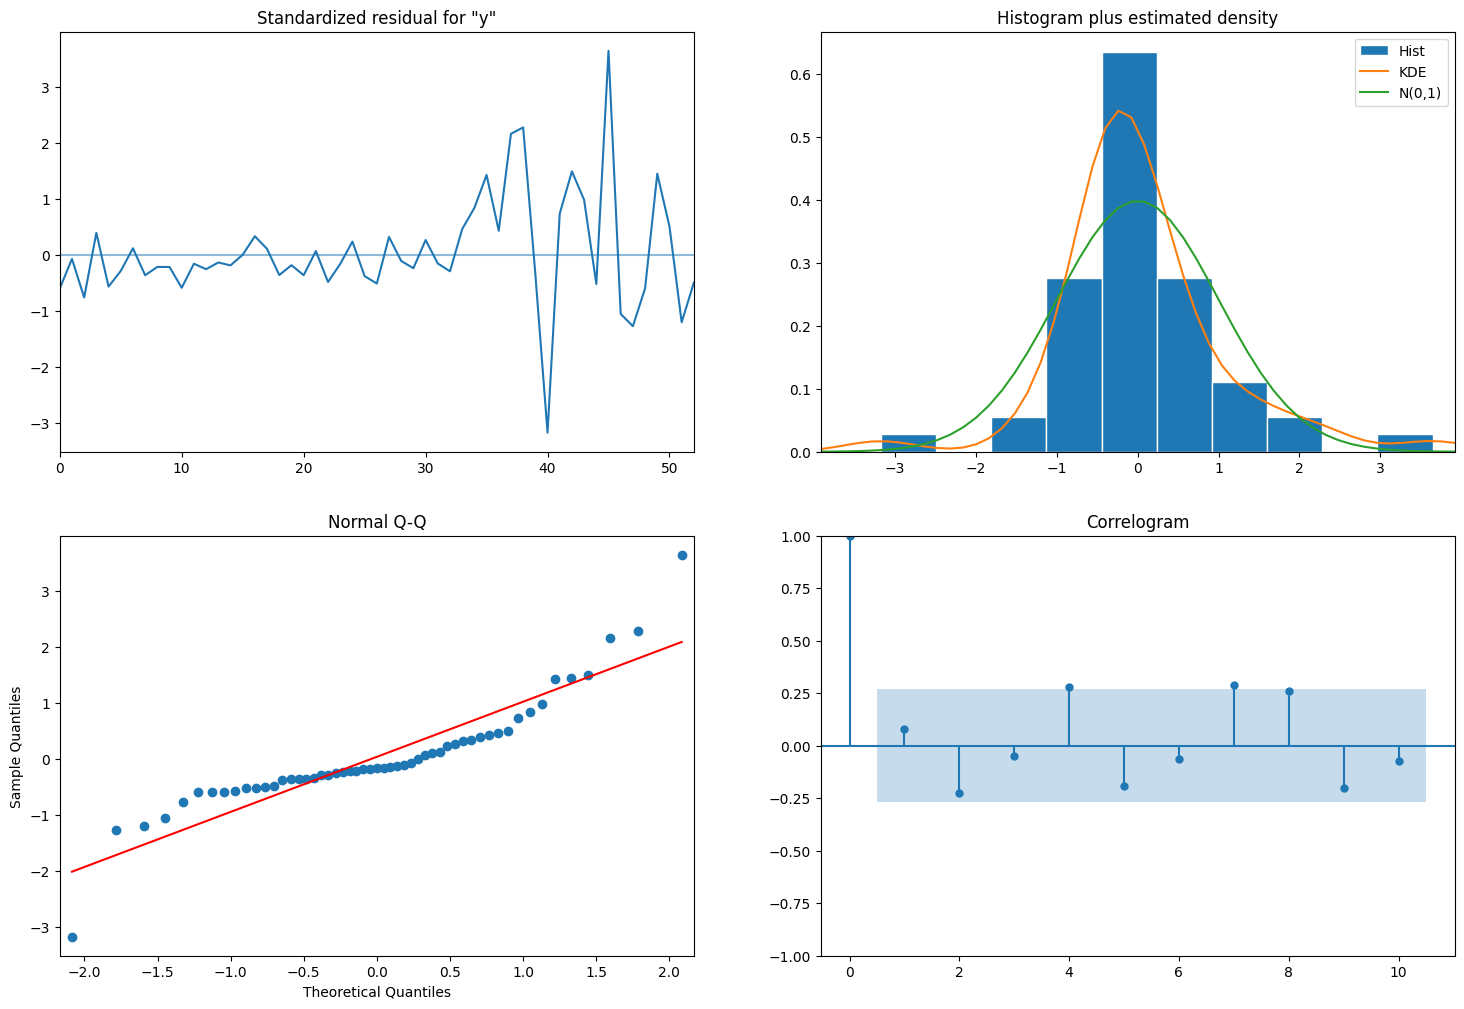

-------------------
PREVISÃO
-------------------


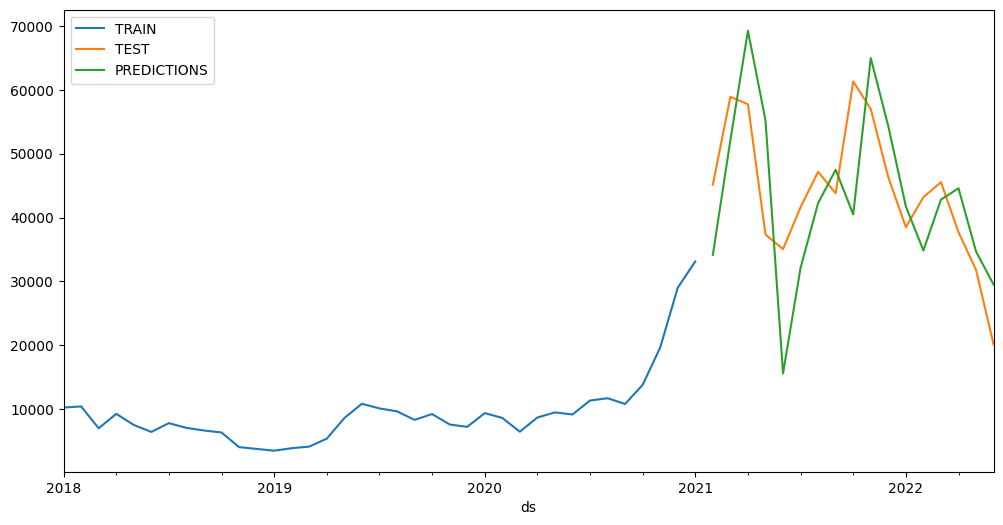

                        model           mse          rmse          mae  \
0  AR(2)(incremental_testing)  1.129677e+08  10628.627168  9119.437358   

        r2       mape      smape  
0 -0.05475  21.997101  22.785489  


In [ ]:
pred_ar2_met, ar2_met = model_evaluation(train, test, 2, 0, 0)

# Modelo MA

## MA(1)

MA(1)(single_testing)
------------------
MODELO
------------------
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   37
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -356.908
Date:                Tue, 15 Apr 2025   AIC                            719.816
Time:                        12:36:06   BIC                            724.648
Sample:                    01-31-2018   HQIC                           721.519
                         - 01-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9808.0399   1217.772      8.054      0.000    7421.252    1.22e+04
ma.L1          0.9034      0.064     14.101      0.000       0.7

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


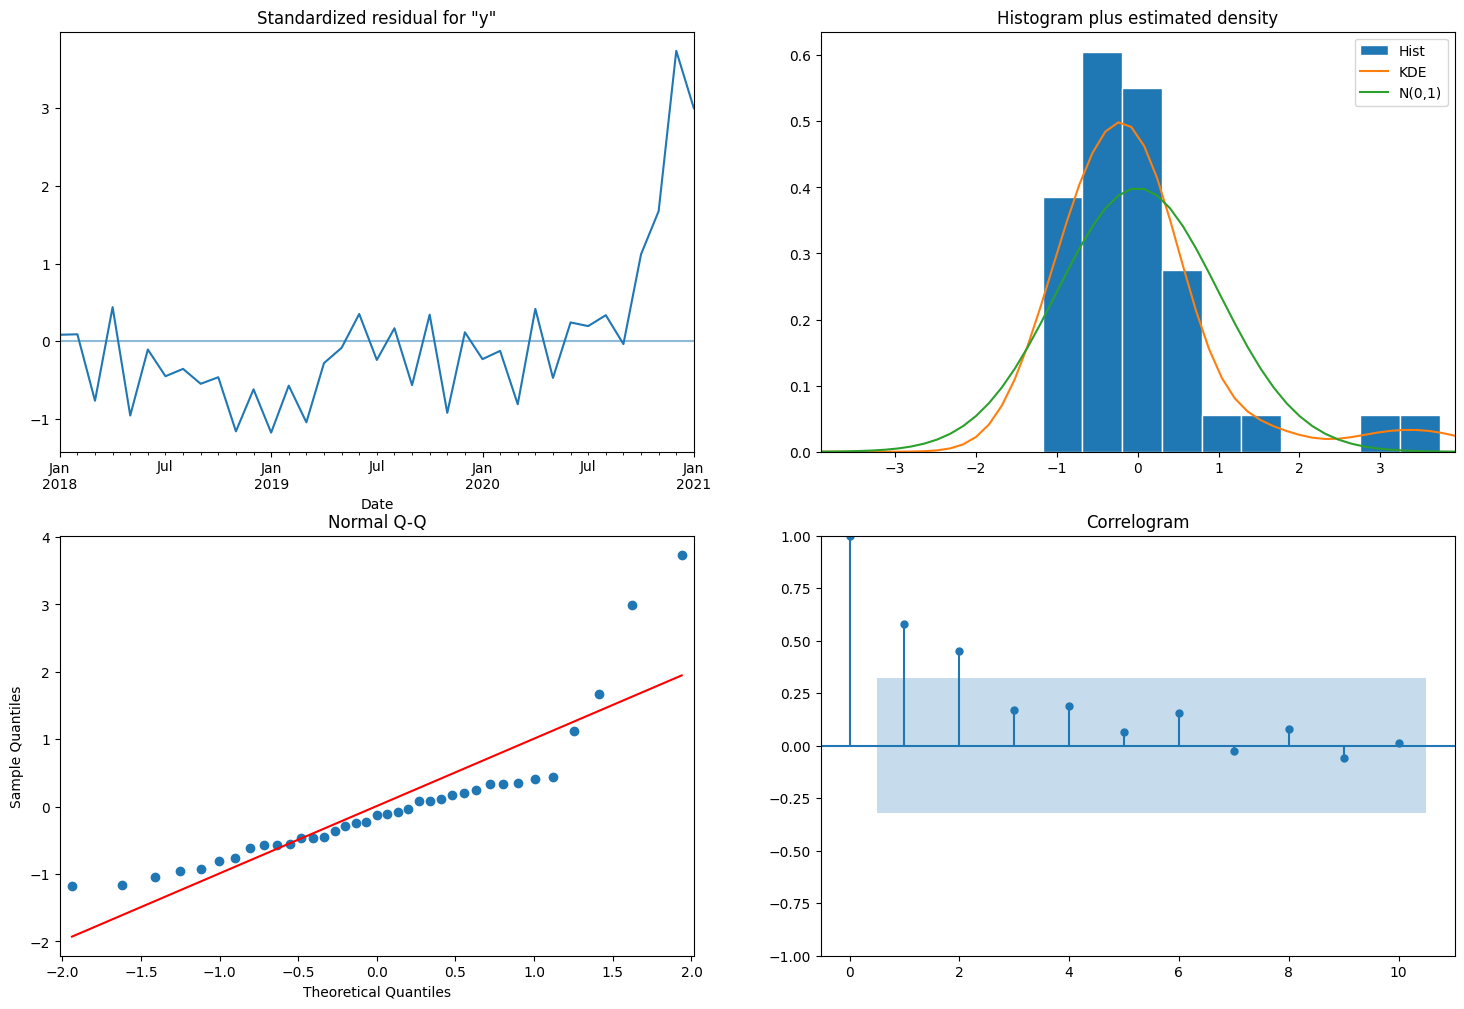

-------------------
PREVISÃO
-------------------


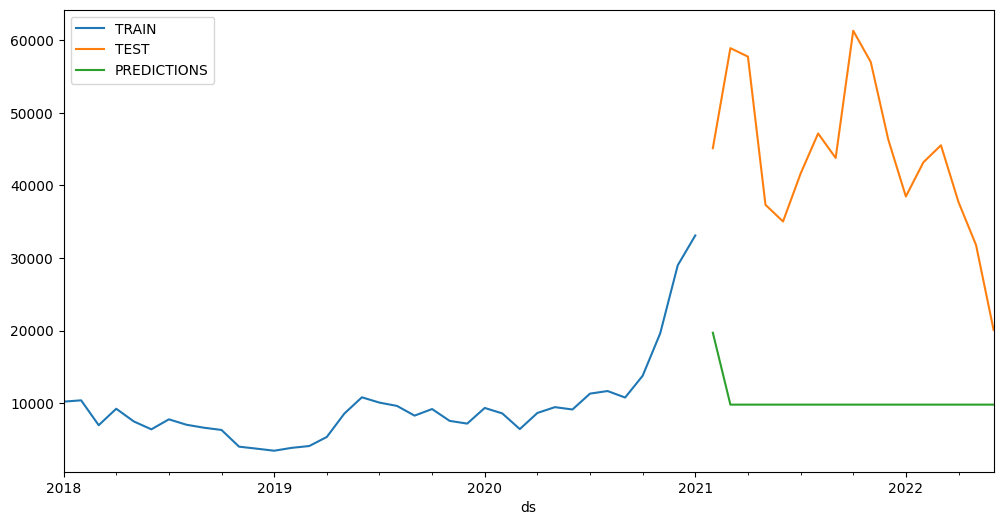

                   model           mse          rmse           mae         r2  \
0  MA(1)(single_testing)  1.241690e+09  35237.622626  33622.412583 -10.593337   

        mape       smape  
0  74.819286  120.957172  
MA(1)(incremental_testing)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


------------------
MODELO
------------------
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   53
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -575.614
Date:                Tue, 15 Apr 2025   AIC                           1157.229
Time:                        12:36:08   BIC                           1163.140
Sample:                             0   HQIC                          1159.502
                                 - 53                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.044e+04   6821.621      2.997      0.003    7072.529    3.38e+04
ma.L1          0.8189      0.228      3.595      0.000       0.372       1.265
sigma2 

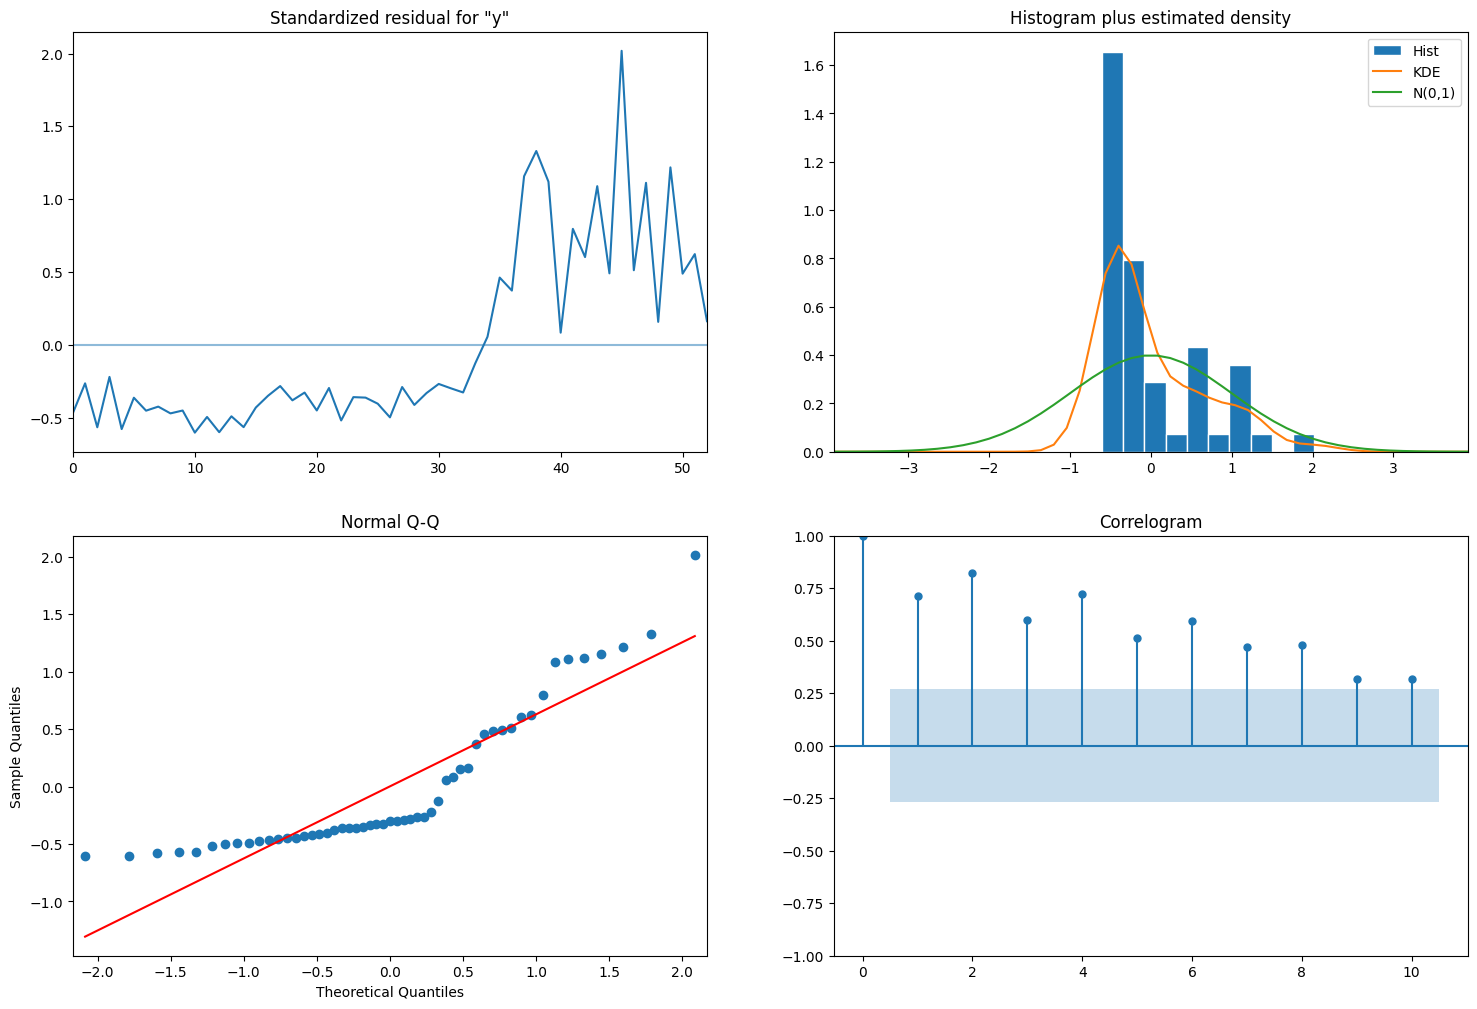

-------------------
PREVISÃO
-------------------


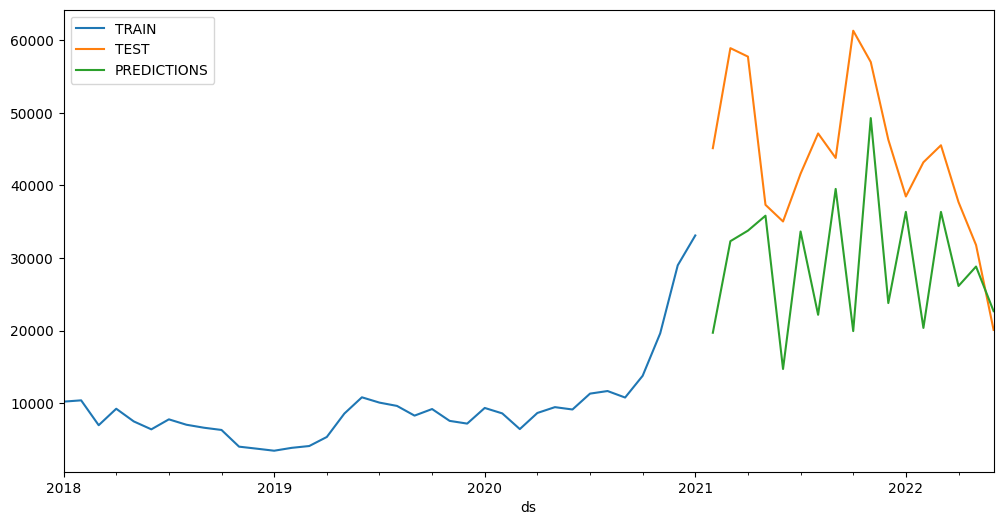

                        model           mse          rmse           mae  \
0  MA(1)(incremental_testing)  3.580355e+08  18921.825744  15168.081578   

         r2       mape      smape  
0 -2.342884  32.221363  42.165473  


In [ ]:
pred_ma1_met, ma1_met = model_evaluation(train, test, 0, 0, 1)

# Results

## Best Forecast

In [ ]:
preds_met = pd.concat([pred_arima221_met, pred_arima220_met, pred_arima021_met, pred_arima111_met, pred_arima110_met, pred_arima011_met, pred_ar1_met, pred_ar2_met, pred_ma1_met], axis=0)
preds_met


model           mse          rmse  \
0       ARIMA(2,2,1)(single_testing)  2.441001e+09  49406.491662   
0  ARIMA(2,2,1)(incremental_testing)  1.520765e+08  12331.929156   
0       ARIMA(2,2,0)(single_testing)  2.734754e+09  52294.879798   
0  ARIMA(2,2,0)(incremental_testing)  1.541356e+08  12415.135954   
0       ARIMA(0,2,1)(single_testing)  2.331931e+09  48290.076267   
0  ARIMA(0,2,1)(incremental_testing)  1.429212e+08  11954.966038   
0       ARIMA(1,1,1)(single_testing)  2.341841e+08  15303.075672   
0  ARIMA(1,1,1)(incremental_testing)  1.201966e+08  10963.420059   
0       ARIMA(1,1,0)(single_testing)  1.819537e+08  13489.022736   
0  ARIMA(1,1,0)(incremental_testing)  9.655928e+07   9826.458206   
0       ARIMA(0,1,1)(single_testing)  2.296424e+08  15153.956395   
0  ARIMA(0,1,1)(incremental_testing)  9.616590e+07   9806.421263   
0              AR(1)(single_testing)  2.944452e+08  17159.406827   
0         AR(1)(incremental_testing)  9.404463e+07   9697.660948   
0              AR(2)(single_testing)  5.417684e+08  23275.919830   
0         AR(2)(incremental_testing)  1.129677e+08  10628.627168   
0              MA(1)(single_testing)  1.241690e+09  35237.622626   
0         MA(1)(incremental_testing)  3.580355e+08  18921.825744   

            mae         r2        mape       smape  
0  40707.432144 -21.790994  114.623500   60.748666  
0  10139.052584  -0.419898   24.744366   23.081878  
0  43131.942749 -24.533690  121.219225   62.761561  
0  10197.668420  -0.439124   24.234099   23.217382  
0  39763.335506 -20.772637  112.033675   59.883095  
0   9806.289077  -0.334418   24.923306   24.942698  
0  12872.234243  -1.186516   28.001752   31.970390  
0   9274.470665  -0.122244   22.403612   21.601445  
0  10898.689007  -0.698855   24.237874   26.330884  
0   8669.295878   0.098451   20.976912   20.036849  
0  12715.630725  -1.144111   27.697242   31.509568  
0   8327.302773   0.102124   20.069902   19.520660  
0  15031.910760  -1.749159   32.169834   38.712385  
0   7941.250942   0.121930   19.419699   18.735860  
0  21211.858499  -4.058351   46.672364   63.405439  
0   9119.437358  -0.054750   21.997101   22.785489  
0  33622.412583 -10.593337   74.819286  120.957172  
0  15168.081578  -2.342884   32.221363   42.165473

### Single Training

In [ ]:
preds_met_single = preds_met[preds_met['model'].str.contains('single')]
preds_met_single = rank_models(preds_met_single)
preds_met_single[preds_met_single['final_rank']<=3]

model           mse          rmse           mae  \
0  ARIMA(1,1,0)(single_testing)  1.819537e+08  13489.022736  10898.689007   
1  ARIMA(0,1,1)(single_testing)  2.296424e+08  15153.956395  12715.630725   
2  ARIMA(1,1,1)(single_testing)  2.341841e+08  15303.075672  12872.234243   

         r2       mape      smape  rank_mse  rank_rmse  rank_mae  rank_r2  \
0 -0.698855  24.237874  26.330884       1.0        1.0       1.0      1.0   
1 -1.144111  27.697242  31.509568       2.0        2.0       2.0      2.0   
2 -1.186516  28.001752  31.970390       3.0        3.0       3.0      3.0   

   rank_mape  rank_smape  final_rank  
0        1.0         1.0         1.0  
1        2.0         2.0         2.0  
2        3.0         3.0         3.0

### Incremental Training

In [ ]:
preds_met_inc = preds_met[preds_met['model'].str.contains('inc')]
preds_met_inc = rank_models(preds_met_inc)
preds_met_inc[preds_met_inc['final_rank']<=3]

model           mse         rmse          mae  \
0         AR(1)(incremental_testing)  9.404463e+07  9697.660948  7941.250942   
1  ARIMA(0,1,1)(incremental_testing)  9.616590e+07  9806.421263  8327.302773   
2  ARIMA(1,1,0)(incremental_testing)  9.655928e+07  9826.458206  8669.295878   

         r2       mape      smape  rank_mse  rank_rmse  rank_mae  rank_r2  \
0  0.121930  19.419699  18.735860       1.0        1.0       1.0      1.0   
1  0.102124  20.069902  19.520660       2.0        2.0       2.0      2.0   
2  0.098451  20.976912  20.036849       3.0        3.0       3.0      3.0   

   rank_mape  rank_smape  final_rank  
0        1.0         1.0         1.0  
1        2.0         2.0         2.0  
2        3.0         3.0         3.0

### In Both Training

In [ ]:
preds_met_global = rank_models(preds_met)
preds_met_global[preds_met_global['final_rank']<=3]

model           mse         rmse          mae  \
0         AR(1)(incremental_testing)  9.404463e+07  9697.660948  7941.250942   
1  ARIMA(0,1,1)(incremental_testing)  9.616590e+07  9806.421263  8327.302773   
2  ARIMA(1,1,0)(incremental_testing)  9.655928e+07  9826.458206  8669.295878   

         r2       mape      smape  rank_mse  rank_rmse  rank_mae  rank_r2  \
0  0.121930  19.419699  18.735860       1.0        1.0       1.0      1.0   
1  0.102124  20.069902  19.520660       2.0        2.0       2.0      2.0   
2  0.098451  20.976912  20.036849       3.0        3.0       3.0      3.0   

   rank_mape  rank_smape  final_rank  
0        1.0         1.0         1.0  
1        2.0         2.0         2.0  
2        3.0         3.0         3.0

# Conclusion


A partir da condução de experimentos comparativos envolvendo diversos modelos da família ARIMA, AR e MA, avaliados sob diferentes estratégias de treinamento (single testing e incremental testing), chegamos aos seguintes resultados:

* Top 3 modelos:

  * ARIMA(2,2,1) — single testing – menor AIC, BIC e HQIC, porém com baixo desempenho preditivo.

  * ARIMA(2,2,0) — single testing – desempenho semelhante ao anterior nos critérios de ajuste.

  * ARIMA(0,2,1) — single testing – também com bom ajuste estatístico, mas com altos erros de previsão.

* Top 3 forecasts:

  * AR(1) – incremental testing - melhor desempenho geral, com menores erros e maior R².
  
  * ARIMA(0,1,1) – incremental testing - desempenho muito próximo, com leve vantagem em SMAPE.

  * ARIMA(1,1,0) – incremental testing - bom desempenho, embora inferior aos dois anteriores.

Os resultados sugerem que os modelos com diferenciação única (d = 1) superaram aqueles com dupla diferenciação (d = 2) em todas as métricas de avaliação (MSE, RMSE, MAE, MAPE, SMAPE e R²). Assim, apesar de o modelo auto_arima ter previamente indicado d = 2 como valor ideal, os forecasts confirmaram a suspeita inicial de possível superdiferenciação, o que comprometeu a capacidade preditiva dos modelos mais complexos.

Conclui-se, portanto, para o presente caso, que modelos simples, com estrutura autoregressiva de primeira ordem ou com um único termo de média móvel aplicado à série diferenciada uma vez, mostraram-se mais eficazes para previsão neste caso. Isso reforça a importância de não depender exclusivamente da otimização automatizada de hiperparâmetros (como no auto_arima), mas de considerar a estrutura da série e o desempenho prático dos modelos em previsão real.